# Multilayer perceptron classifiers and regularization

## Introduction: what are we doing in this notebook?

In previous work of Julian's, the following paradigm performed well enough to become our baseline:
*   We use HuBERT to extract a vector of features from the audio files.
    *    Different feature extractors are also fine here.
    *    We are also free to use noised or un-noised audio here.
*    Send these features through a (regularized) logistic regression, to act as a classifier.

Julian has also been experimenting with replacing this second step - the classifier - with a multi-layer fully connected feed forward network (a multilayer perceptron, or MLP). Furthermore:
*   Julian's MLP classifier layer is trained on data from a single participant at a time.
*   Julian tried $2$ and $3$ layers, with only minor improvement from including the third layer.
*   Julian worked with ReLU units.

There is a distinct problem - we are wildly overfitting here, even with only a 2-layer MLP. Indeed, even with a depth 1 feed forward classifier (i.e. logistic or softmax classifier) there are too many degrees of freedom, since HuBERT produces feature vectors of in $\mathbb{R}^{768}$. When working with a "depth 1" classifier, we confronted this using regularized logistic regression, using `skopt` to find an optimum value for the regularization hyper-parameter $C$.

For a multi-layer classifier, we should probably do something more to reduce overfitting. In this notebook, we see how some classic regularization techniques perform. We try out:
* Early stopping.
* Introducing weight penalties to the loss function through L2 regularization.
* Dropout.
* Using AdamW as optimizer.

Throughout this notebook, we will be using early stopping; in specific sections, we will add in these other techniques. In another notebook, we will carry out some hyperparameter tuning, which should give us a best result.




In this notebook, all performance is evaluated on P05. In the sequel, `Hyperparametertuning.ipynb`, we work also with P01.

## Imports and installs

We assume that this notebook sits in a folder with a folder caled `/data/` which itself contains the recanvo audio files in a subfolder `/data/wav/`. When running this notebook in Google colab, I mount Google drive.

In [1]:
"""from google.colab import drive
drive.mount('/content/drive/') #Making Google drive accessible."""

"from google.colab import drive\ndrive.mount('/content/drive/') #Making Google drive accessible."

In [2]:
#drive.mount("/content/drive/", force_remount=True)

In [3]:
# %cd /content/drive/MyDrive/erdos_recanvo_project

In [4]:
import functools
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

In [5]:
label_metrics=list(metrics.keys())
label_metrics.remove('logloss')

## Preliminaries

In [6]:
# Pretrained HuBERT model
bundle = torchaudio.pipelines.HUBERT_BASE
HuBERT = bundle.get_model()

In [7]:
# List of data files
data_files = pd.read_csv("../data/tt_small_sessions.csv") #using Ale's train-test split
label_counts = data_files.Label.value_counts()
len(data_files.loc[data_files.Label.isin(label_counts[label_counts >= 30].index)].Label.unique())

11

There are 11 labels, among all participants, that appear often enough to consider. We will need to have way to zip together the labels and an index for later.

In [8]:
all_labels=list(data_files.loc[data_files.Label.isin(label_counts[label_counts >= 30].index)].Label.unique())
all_labels_dict=dict(zip(all_labels, range(len(all_labels))))


We work with the test-train split created by Ale. This split is designed to hold entire sessions out of the the training set. Since our test-train split was stratified by label, the labels that occur in `train` should be exactly those occurring in `test`.

In [9]:
training_files = data_files.loc[
    data_files.Label.isin(label_counts[label_counts >= 30].index) & (data_files.is_test == 0)
                                ].copy()
display(training_files.Label.value_counts())

Label
selftalk              1372
frustrated            1109
delighted              865
dysregulated           522
social                 439
request                287
affectionate           103
yes                     94
laughter                66
dysregulation-sick      59
happy                   46
Name: count, dtype: int64

We also take a look at what HuBERT outputs. Here I follow the lead that Julian laid out in a previous notebook. Namely, he pointed out that HuBERT outputs (on a single audio file) a tensor of size $(m,n,768)$ where $m=1,2$ is the number of channels, and $n$ depends on the length of the clip.

* In the example below, $m=2$. It makes sense to average over these two channels.
* Doing some reading, it seems that HuBERT works as follows: it take overlapping time segments, and uses some transformer architecture to peel out a tensor of features within each time segment. $n$ is the number of time segments.

We can see this in an example in the next two code boxes.

In [10]:
# Extract acoustic features from one wav file using HuBERT

datadir = Path("../data/wav")
filename = training_files.Filename.iloc[0]
waveform, sample_rate = torchaudio.load(datadir / filename)
waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate) #resample the audio to be at the rate HuBERT expects (16KHz).
features, _ = HuBERT.extract_features(waveform)

print(f"{type(features)=}, {len(features)=}")
print(features[0].mean((0, 1)).shape)

type(features)=<class 'list'>, len(features)=12
torch.Size([768])


In [11]:
for i in range(len(features)):
  print(features[i].shape)

torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])
torch.Size([2, 12, 768])


`features` is a list of $12$ tensors, each having shape $(m, n, 768)$ as discussed above. The $12$ comes from the number of hidden layers in base HuBERT. In the above we looked at the first of these (i.e. the most primitive features) and averaged over channels and time ($m$ and $n$).

### Assembling the HuBERT outputs into a `Dataset`.

Here is a `Dataset` class that, after inputting a dataframe with a column "Filename" listing audio files we want, holds a tensor of the HuBERT features running for files in that dataframe. WARNIING: this class runs a forward pass of HuBERT each time you use it to retrieve a recording, so be careful to save features so as to not waste time recomputing. 


In [12]:
class UncomputedFeatures(Dataset):
    def __init__(self, df, labels=[], root_dir=Path("../data/wav")): #To construct a Features object, you feed in a dataframe with column "Filename" with the names of the audio files.
        self.df=df
        self.root_dir=root_dir
        if labels==[]:
            labels=self.df.Label.unique() # if no list of labels is provided, take the labels appearing in df
        self.labeldict=dict(zip(labels, range(len(labels)))) #keeps track of the labels and zips them with numerical values 0,1,...


    def __getitem__(self, idx): #idx an index of dataframe
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        filename = self.df.Filename.iloc[idx]
        waveform, sample_rate = torchaudio.load(self.root_dir / filename)
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate) #resample the audio to be at the rate HuBERT expects (16KHz).
        features, _ = HuBERT.extract_features(waveform)
        X=features[0].mean((0, 1))
        y=torch.zeros(len(self.labeldict)).detach()
        y[self.labeldict[self.df.Label.iloc[idx]]]=1
        z = self.labeldict[self.df.Label.iloc[idx]] #z is the integer corresponding to our label. We return z for use in train-test splits through sklearn - I had problems making this happy with tensor objects in the stratify variable
        return X.detach(), y , z

    def __len__(self):
        return len(self.df)

Here's a dataset class that works better when HuBERT files have been precomputed.

In [13]:
class PrecomputedFeatures(Dataset):
    def __init__(self, df, labels=[], root_dir=Path("../data/wav")): #To construct a Features object, you feed in a dataframe with column "Filename" with the names of the audio files, as well as a list of expected labels.
        self.df=df
        self.root_dir=root_dir
        if labels==[]:
            labels=self.df.Label.unique() # if no list of labels is provided, take the labels appearing in df
        self.labeldict=dict(zip(labels, range(len(labels)))) #keeps track of the labels and zips them with numerical values 0,1,...


    def __getitem__(self, idx): #idx is an index of our dataframe
        if torch.is_tensor(idx):
            idx = idx.tolist()
        filename = self.df.Filename.iloc[idx]
        X=torch.load('../data/HuBERt_features/'+filename.removesuffix('.wav')+'.pt').detach()
        y=torch.zeros(len(self.labeldict)).detach()
        y[self.labeldict[self.df.Label.iloc[idx]]]=1
        z = self.labeldict[self.df.Label.iloc[idx]]
        return X, y , z #z is the integer corresponding to our label. We return z for use in train-test splits through sklearn - I had problems making this happy with tensor objects in the stratify variable
    def __len__(self):
        return len(self.df)

These custom Dataset classes will be put into a python script for anyone to use as desired.

## MLP classifiers (w/o dropout)

### Models

We define two custom feedforward net classes for our MLP classifier. First, a 2 layer classifier.
The layers are as follows: the first is a fully connected ReLU layer with no compression (768,768); the second is an output linear layer with `num_labels` neurons. We will train the model using `nn.CrossEntropyLoss()`, so in effect this is a softmax layer - however, for inference, we need to remember to take a softmax to see actual probabiities.

 `num_labels` here is the number of labels we are considering: since we will run this network both participant by participant and over the whole dataset, this may change from setting to setting.

In [14]:
class two_layer_classifier(nn.Module):
    def __init__(self, num_labels): #num_labels is the number of labels appearing in the dataframe df we used Features(df), i.e. len(df.Label.unique())
        super().__init__()
        self.norm = nn.BatchNorm1d(768) #including a batch normalization layer instead of StandardScaler() (Julian used StandardScaler() when playing with logistic regression) 
        self.layer1 = nn.Linear(768, 768)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(768, num_labels)

    def forward(self, x):
        x = self.norm(x)
        x = self.act1(self.layer1(x))
        x = self.output(x)
        return x

We also try a 3 layer classifier. Here our layers are simply two fully connected ReLU layer with no compression (768,768), then an output softmax layer with `num_labels` neurons. 

In [15]:
class three_layer_classifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.norm = nn.BatchNorm1d(768)
        self.layer1 = nn.Linear(768, 768)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(768, 768)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(768, num_labels)

    def forward(self, x):
        x = self.norm(x)
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.output(x)
        return x


### Performance

We now evaluate how these models do on P05. First, the dataset in question.

In [16]:
label_counts=training_files[training_files.Participant == 'P05'].Label.value_counts()
P05_t=training_files.loc[(training_files.Participant =='P05') & (training_files.Label.isin(label_counts[label_counts >= 30].index))]
P05_t_dataset=PrecomputedFeatures(P05_t)

In [17]:
P05_t.Label.unique()

array(['happy', 'frustrated', 'dysregulated', 'selftalk', 'delighted'],
      dtype=object)

#### Cross-validation training loop

First, here is a useful function that reads all the data we need from a dataset object. This is helpful when trying to use some sklearn functionality (like `StratifiedKFold`).

In [18]:
def get_all(dataset): #assuming dataset outputs dataset[i] outputs X[i],y[i] where X[i] is a length 768 dim 1 tensor and y[i] is a length num_labels dim 1 tensor
    if type(dataset)==torch.utils.data.dataset.Subset: #need to do this, since dataset.Subset does not inherit the properties of a custom dataset.
        labeldict=dataset.dataset.labeldict
    else:
        labeldict=dataset.labeldict
    X=torch.zeros(len(dataset), len(dataset[0][0]))
    y=torch.zeros(len(dataset), len(labeldict) )
    z=[0]*len(dataset)
    for i in range(len(dataset)):
        X[i], y[i], z[i] = dataset[i]
    return X, y, z


Second, it will help to have a function that reinitializes the weights in the model during training. We will use this between cross-validation splits.

In [19]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data) #initializes using xavier uniform distribution, unif on [-M,M] where M=6/\sqrt(num_inputs+num_outputs). seems to be standard choice.

Here is a utility cross-validation function designed to work with `DataLoader`. It outputs a dictionary `output` with keys given by the keys of the dictionary `metrics` defined by Julian; the values of `output` on a metric name is a datafram containing the training and validation scores of the metric over each epoch (per split.)

In [20]:
# define a cross validation function
def crossvalid(model, #must include model,
               loss=nn.CrossEntropyLoss(), #if using default, model must have outputs a linear layer. If using a custom model, call it custom_loss
               df=P05_t, #if using the default df must have P05_t already loaded in.
               k_fold=5, batch_size=25, n_epochs=100, lr=.01, m=.8, wd=0, random_state=691): 
    dataset=PrecomputedFeatures(df)
    output=dict()
    for metric in metrics.keys(): #populating output with dataframes keeping track of metrics on each epoch, per split
        df=pd.DataFrame()
        df.index.name='Epoch'
        for i in range(k_fold):
            df[f'split_{i}_train']=[0]*n_epochs
            df[f'split_{i}_val']=[0]*n_epochs
        output[metric]=df

    optimizer=optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=m) # change this if you like!
    
    kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=random_state)
    all_features,all_labels, z =get_all(dataset)
    all_features, all_labels = list(all_features), list(all_labels)
    for i, (train_indices, val_indices) in enumerate(kfold.split(all_features,z)):

        model.apply(weights_init) #reset the weights of the model

        print(f"{i}-th Fold:")
        train_set=torch.utils.data.dataset.Subset(dataset,train_indices) #correct dataset for this i-th split of train-indices
        val_set=torch.utils.data.dataset.Subset(dataset,val_indices) #correct dataset for this i-th split of val-indices
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)
        """Now we train:"""
        for epoch in tqdm(range(n_epochs)):
            model.train()
            for X_batch, y_batch, z_batch in train_loader:
                y_pred = model(X_batch)
                train_loss = loss(y_pred, y_batch)
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
            X_train, y_train, z_train=get_all(train_set)
            X_val, y_val, z_val=get_all(val_set)

            model.eval()  #put in evaluation mode to determine predicted values on train and validation sets
            y_train_pred=model(X_train).detach()
            y_val_pred=model(X_val).detach()
            for metric in label_metrics:
                train_metric=metrics[metric](z_train, y_train_pred) #for label_metrics, score needs the z, i.e the actual label. Note the wrapper around f1 score that finds the argmax of y_pred.
                val_metric= metrics[metric](z_val, y_val_pred)
                output[metric].loc[epoch, f'split_{i}_train']=train_metric
                output[metric].loc[epoch, f'split_{i}_val']=val_metric
            train_logloss= metrics['logloss'](y_train, nn.Softmax(dim=1)(y_train_pred)) #need to take softmax of the predictions to get probabilities
            val_logloss= metrics['logloss'](y_val, nn.Softmax(dim=1)(y_val_pred))
            output['logloss'].loc[epoch, f'split_{i}_train']=train_logloss
            output['logloss'].loc[epoch, f'split_{i}_val']=val_logloss
            #print(f"Epoch {epoch}:", f"Train logloss = {train_logloss};", f" Val logloss = {val_logloss}.")
            #print(f"Train F1 = {train_f1}", f"Val F1 = {val_f1}.")
    
    return output
        


#### Two layer classifier (no regularization).

Now we run this for the two layer classifier.

In [21]:
P05_twolayer=two_layer_classifier(len(P05_t.Label.unique()))

In [22]:
P05_two_layer_output = crossvalid(P05_twolayer, lr=5e-4) #I turned down the learning rate since at default I couldn't see loss over the validation set dropping.

0-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

We now plot the scores over the training loop.

In [23]:
def plot_scores(output, k_fold=5):
    for metric in metrics.keys():
        fig, axes= plt.subplots(ncols=5)
        fig.set_figwidth(5*k_fold)
        fig.set_figheight(5)
        fig.suptitle(("Training: " + metric))

        for i in range(k_fold):
            axes[i].plot(output[metric][f'split_{i}_train'], color='r', label="train")
            axes[i].plot(output[metric][f'split_{i}_val'], color='b', label="val")
            axes[i].legend
            axes[i].set_title(f"Split {i}")
        plt.show()

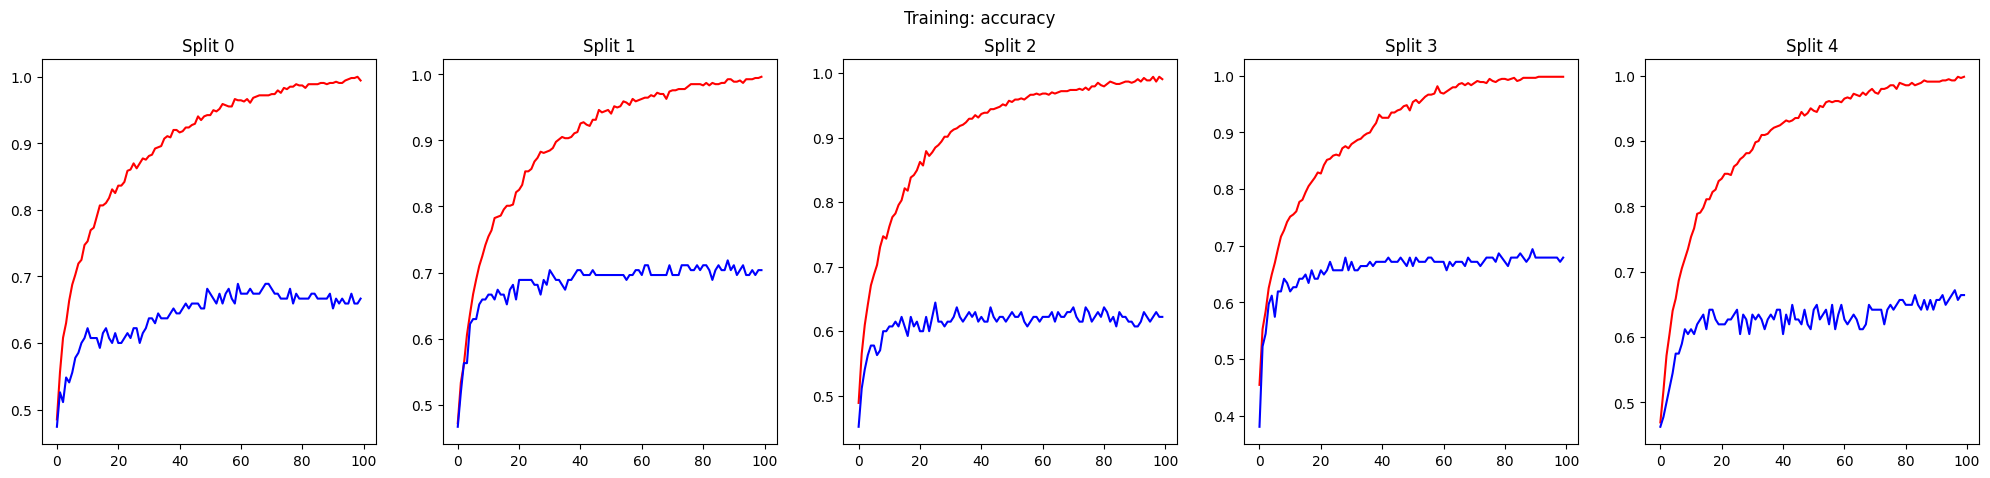

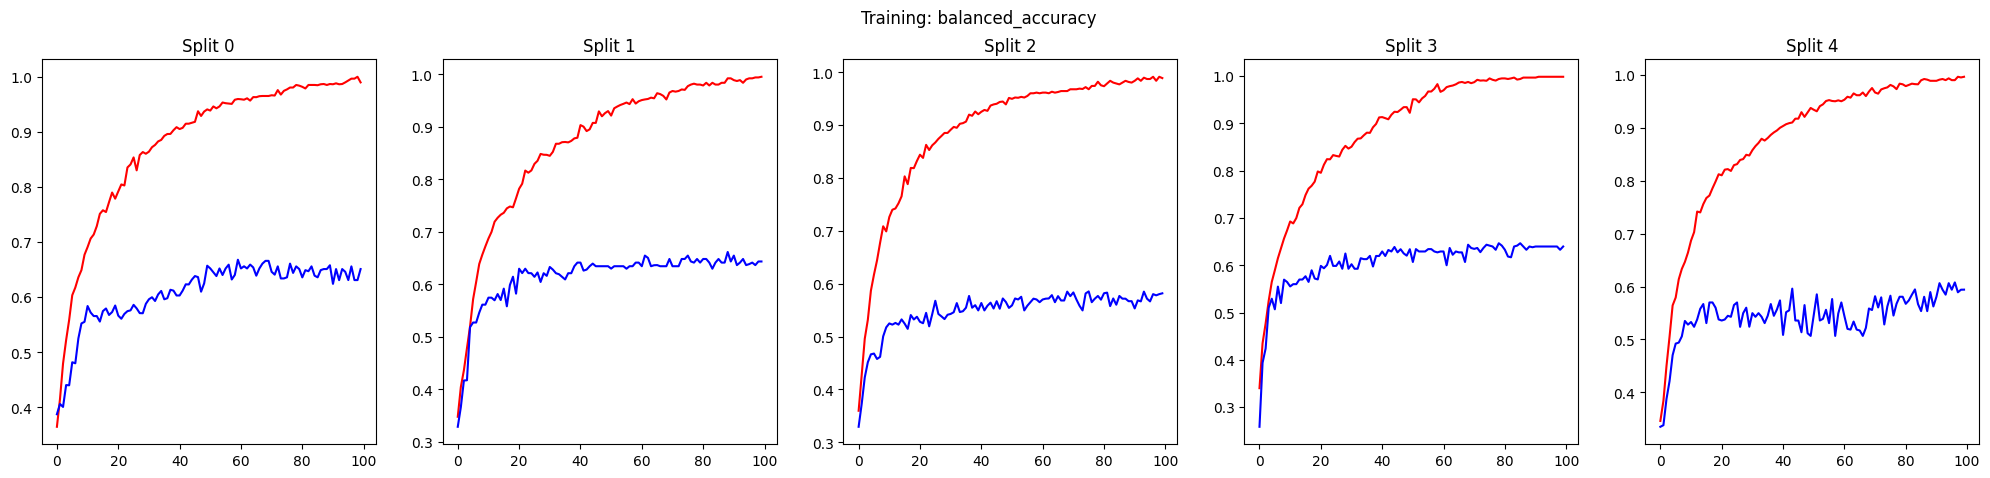

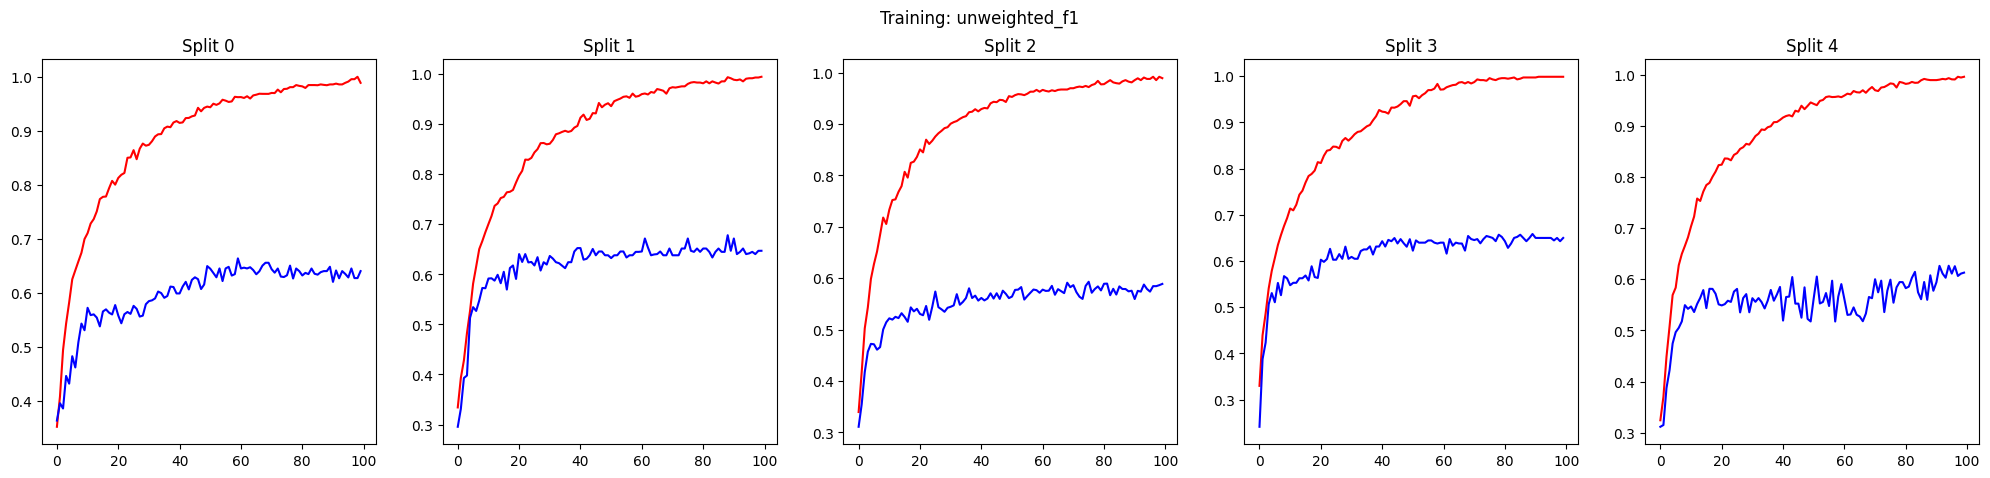

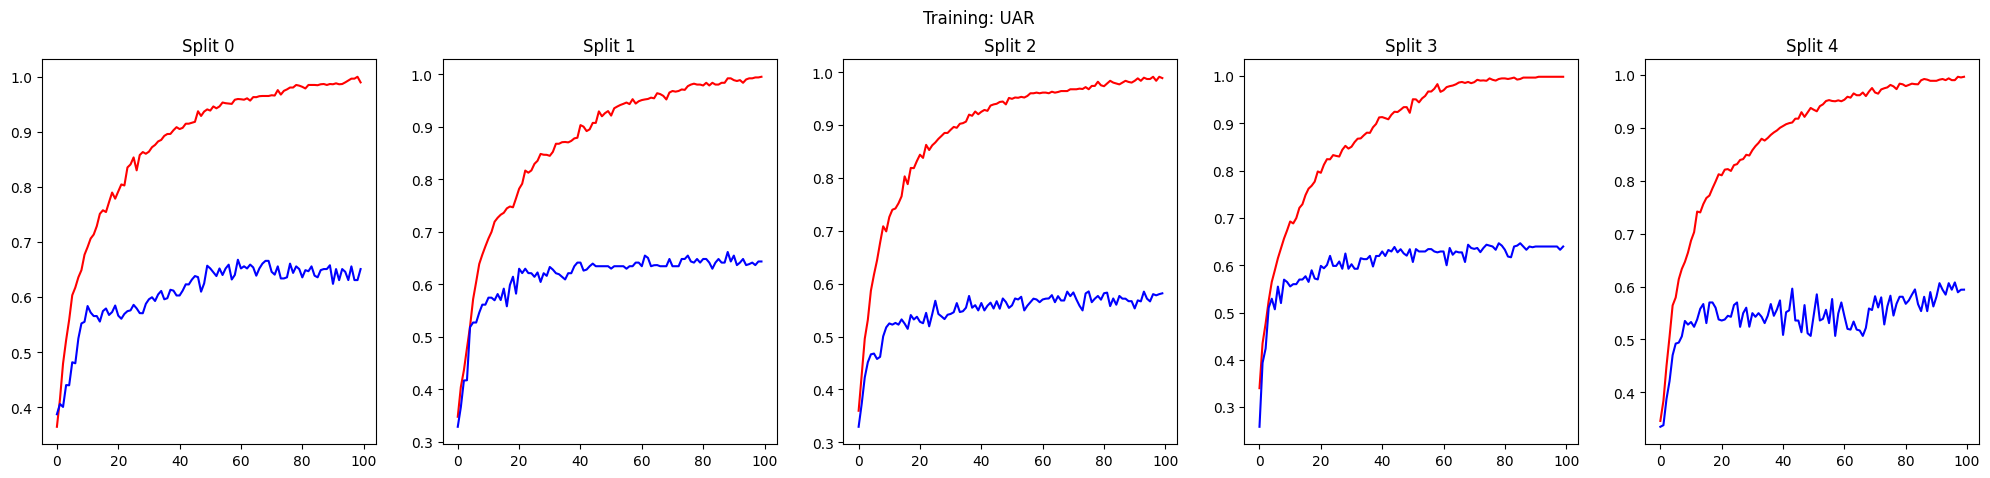

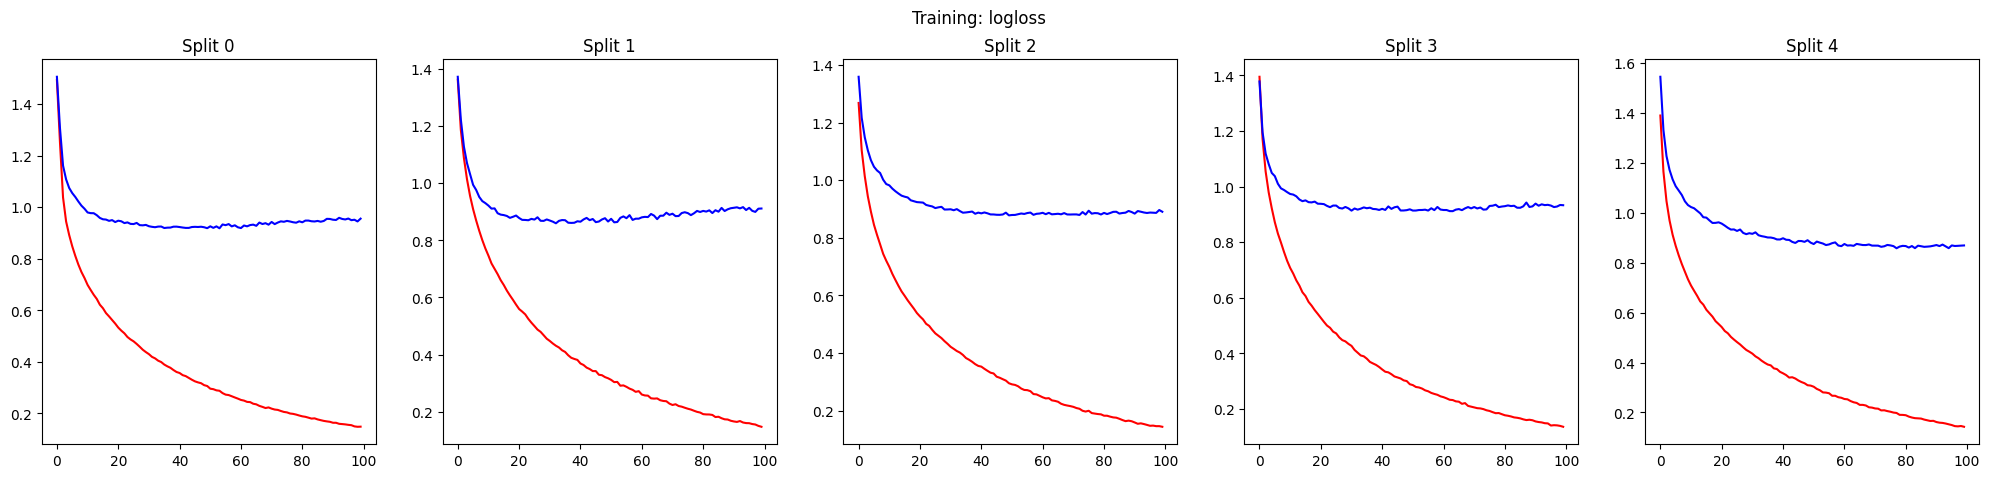

In [24]:
plot_scores(P05_two_layer_output)

Looks a little like overfitting to me. Stopping around 80ish epochs looks like the ideal for `logloss`, which is our loss function for training.

It looks like without any regularization (but with early stopping), the best F1 validation score we get on the two layer classifier is around $.63$. That's surprisingly not shabby. 

In [48]:
sum=0
for i in range(5):
    sum+=P05_two_layer_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop, sum.iloc[80]/5

(0.6300727711688168, 88, 0.6196846120736358)

#### Two layer classifier (with L2 regularization)

We just run the same thing, but with `weight_decay` not set to $0$. This is equivalent to adding an $L2$ penalty to the loss function.

In [26]:
P05_twolayer_L2=two_layer_classifier(len(P05_t.Label.unique()))

I upped the learning rate and the number of epochs in training.

In [27]:
P05_two_layer_L2_output = crossvalid(P05_twolayer_L2, lr=1e-3, wd=.01, n_epochs=300)

0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

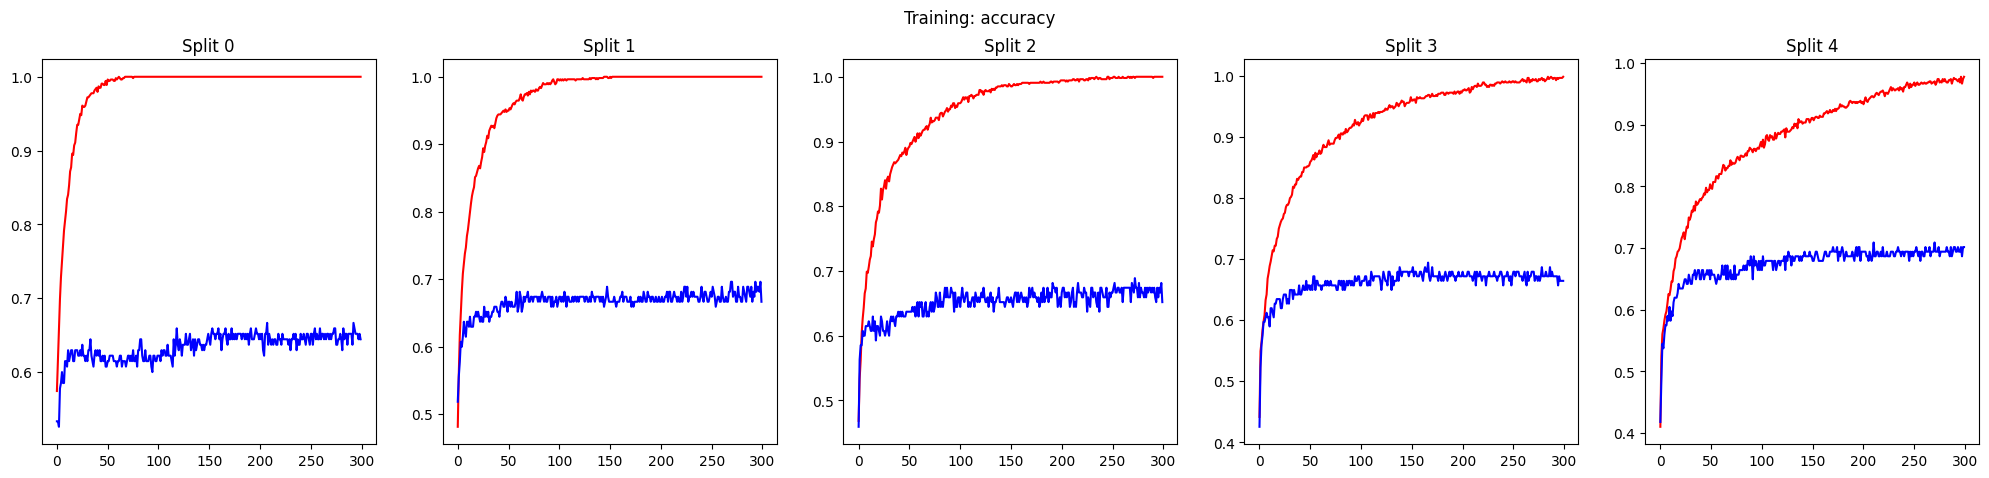

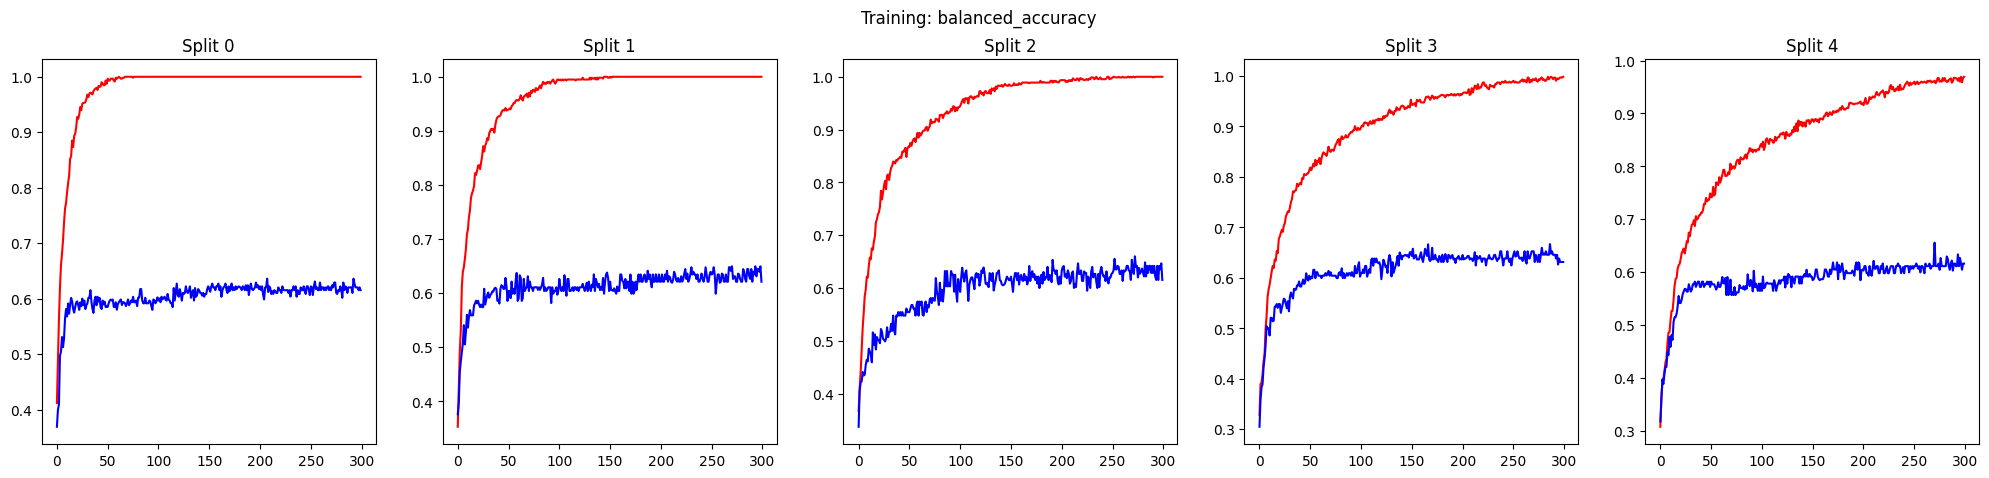

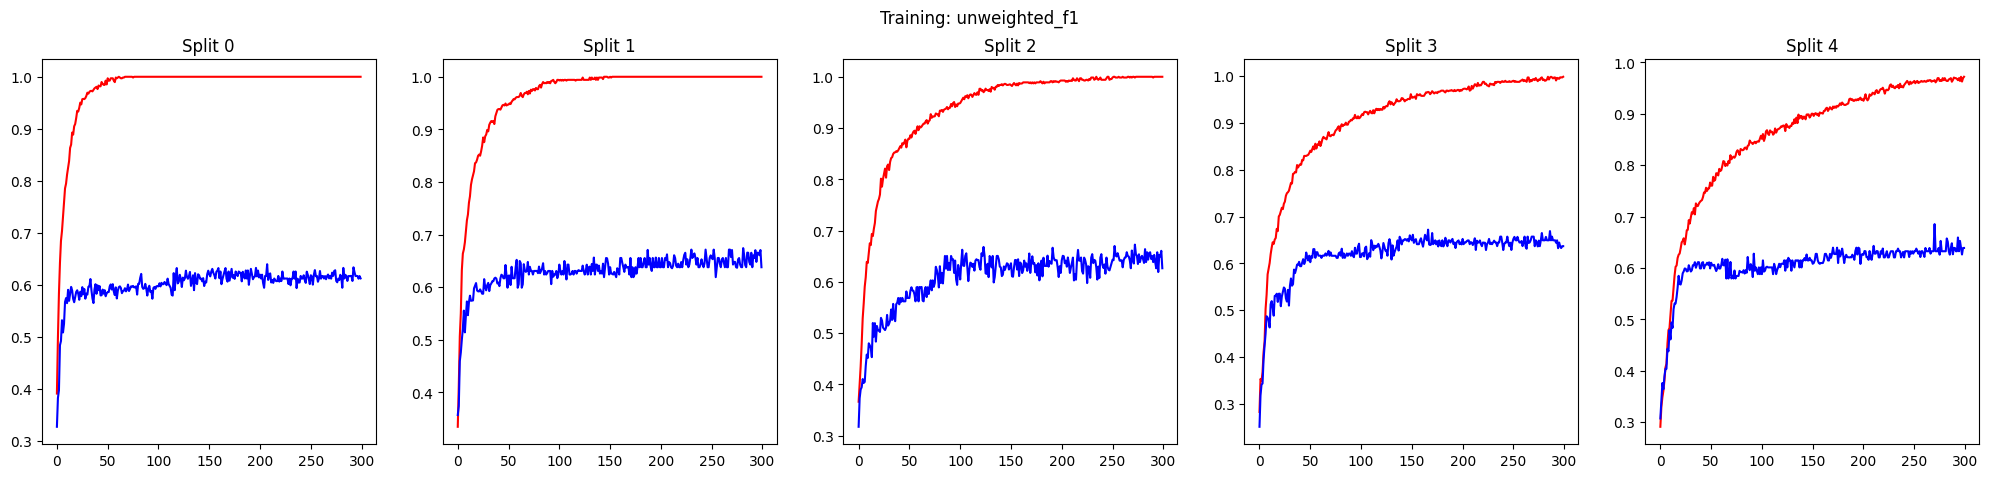

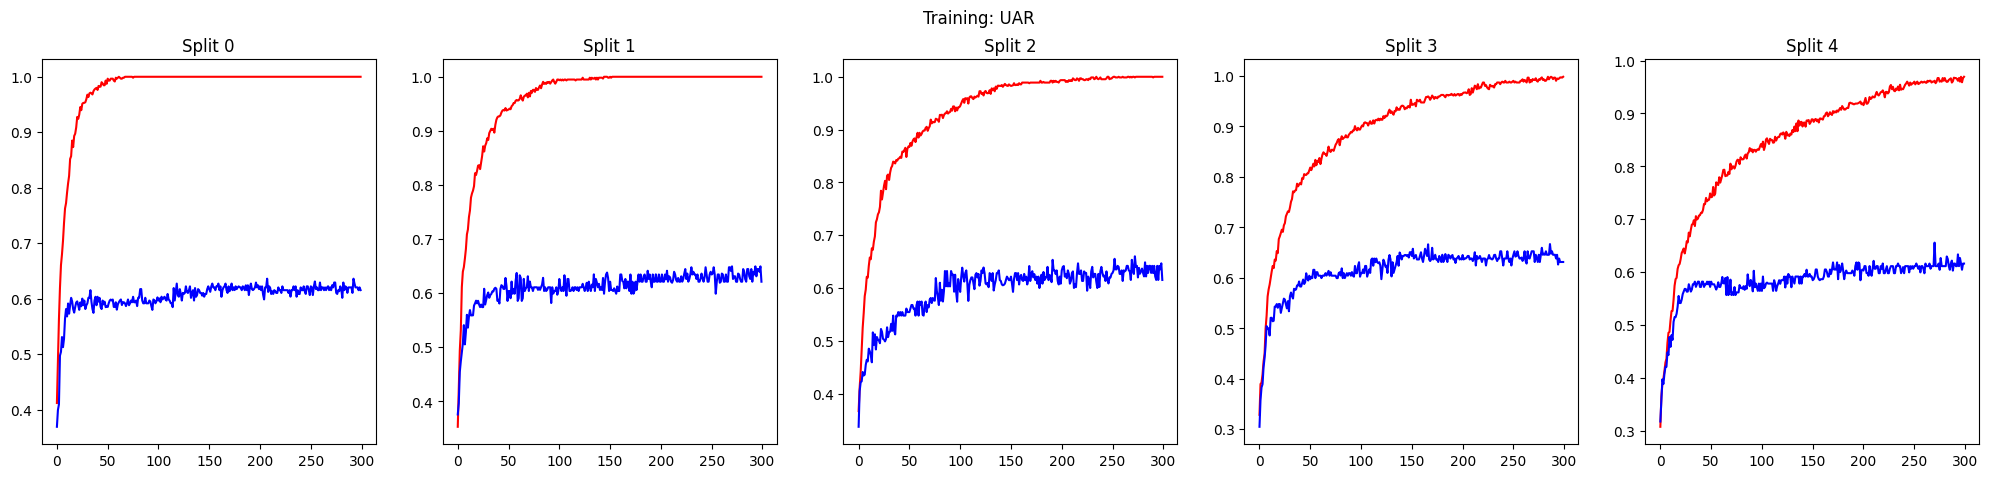

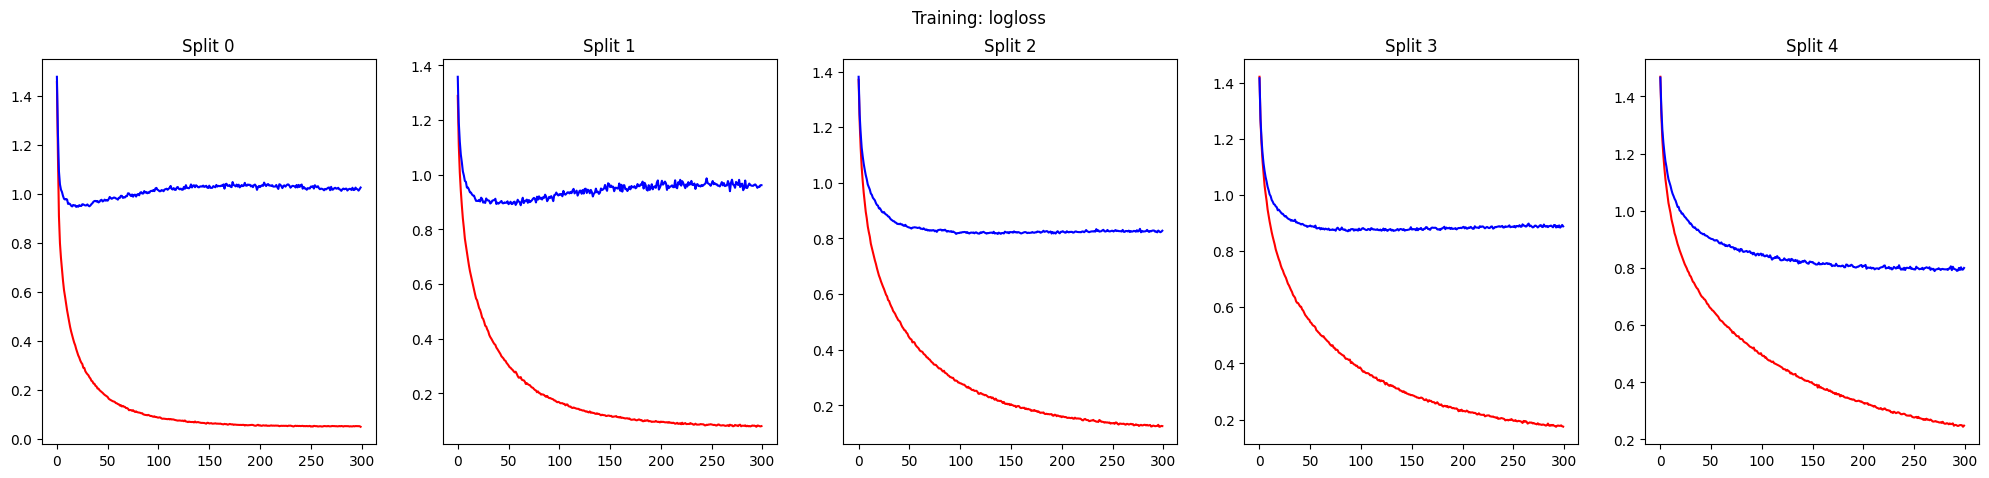

In [28]:
plot_scores(P05_two_layer_L2_output)

Around epoch 50 looks like a good stopping point here. The F1 score improved only a bit. This probably means that our hyperparameters are not tuned well. We'll confront that a little later.

In [29]:
sum=0
for i in range(5):
    sum+=P05_two_layer_L2_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop, sum.iloc[50]/5

(0.6541366482128937, 282, 0.5978231103849084)

Splits 0 and 1 were weird here. 

#### Three layer classifier (no regularization).

Let's try our three layer model.

In [30]:
P05_threelayer=three_layer_classifier(len(P05_t.Label.unique()))

In [31]:
P05_three_layer_output = crossvalid(P05_threelayer, lr=5e-4)

0-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/100 [00:00<?, ?it/s]

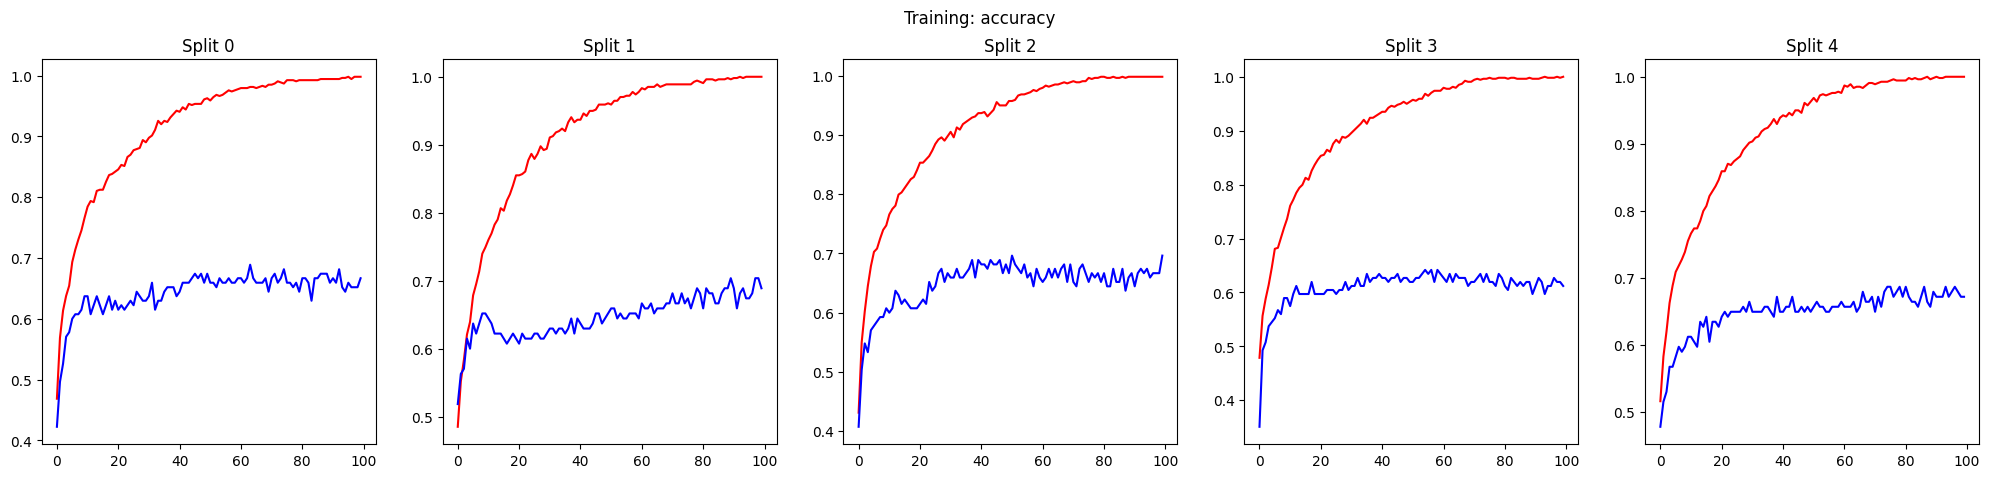

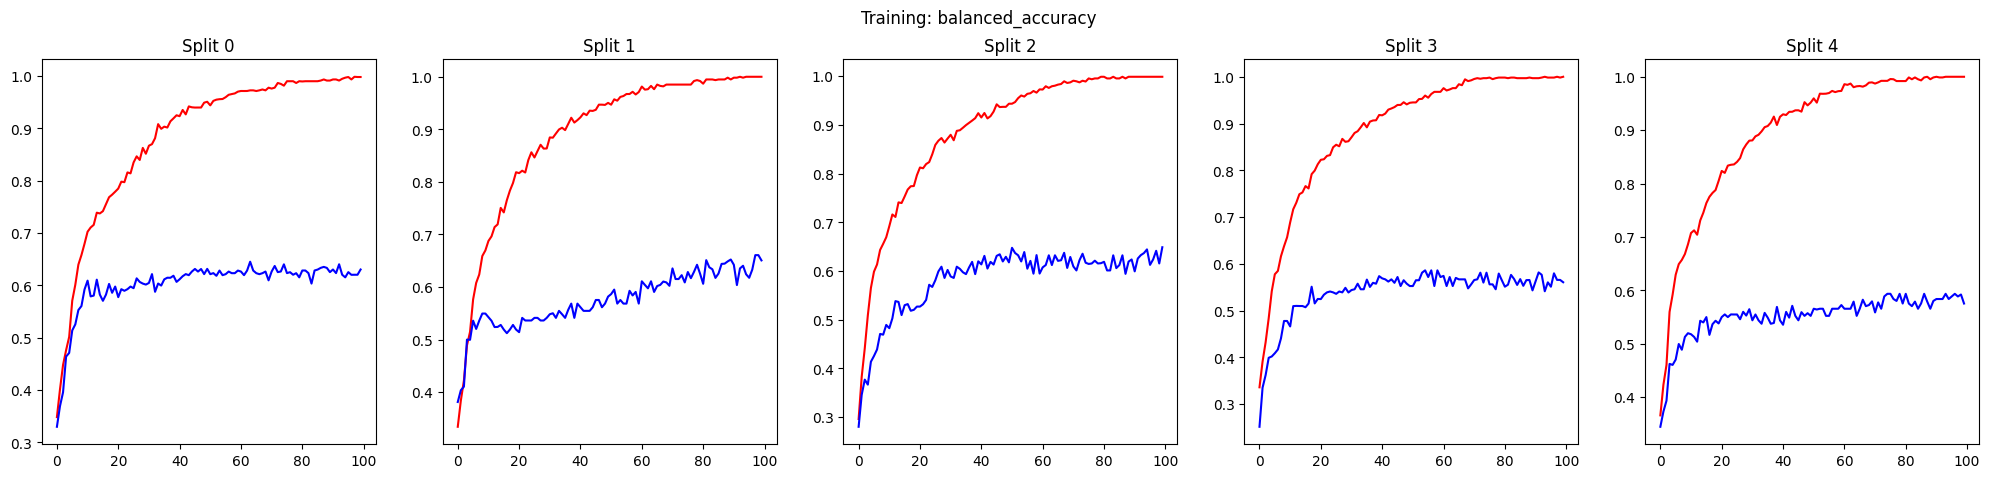

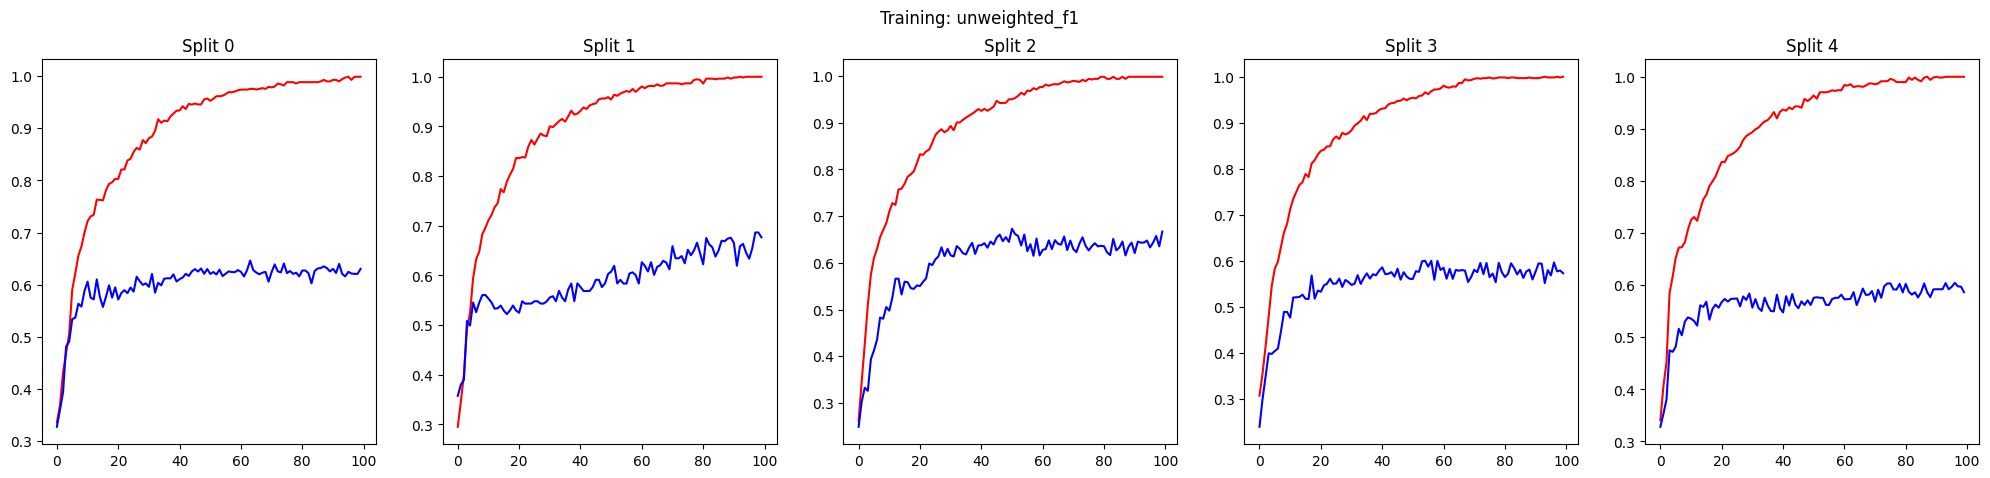

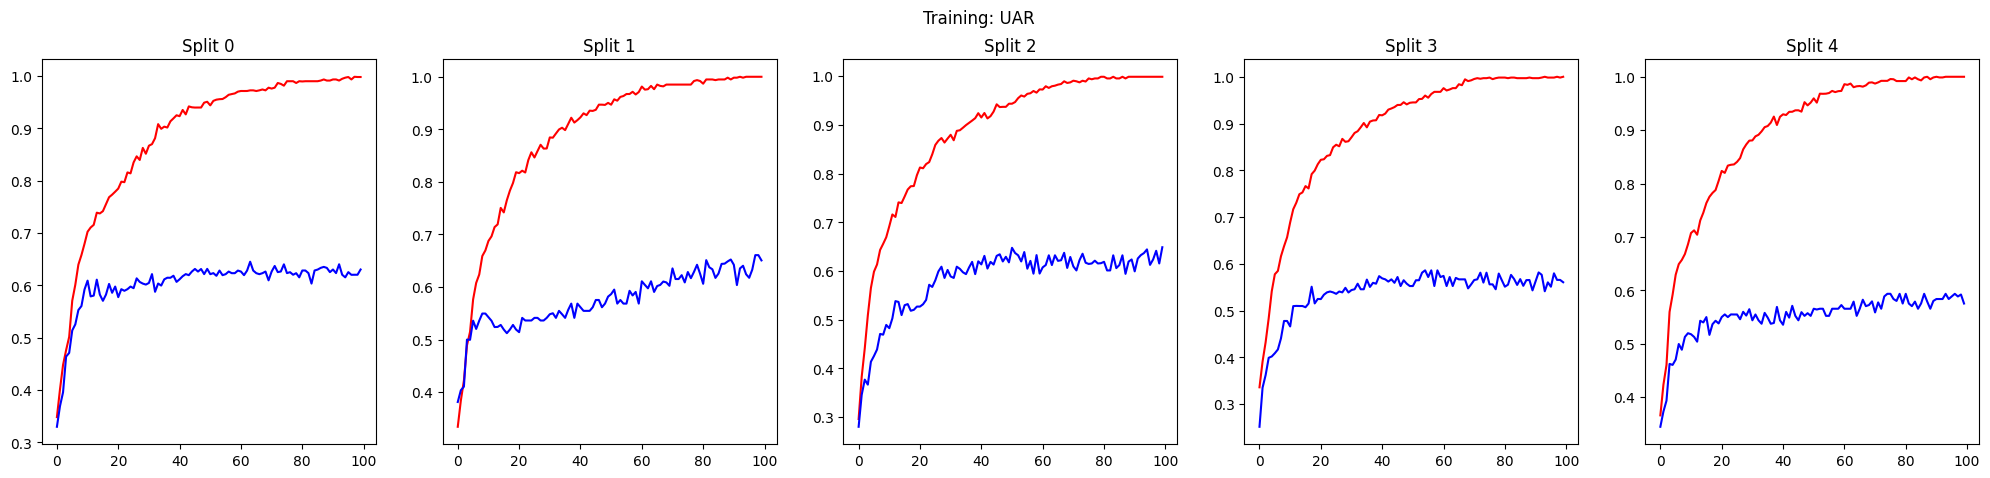

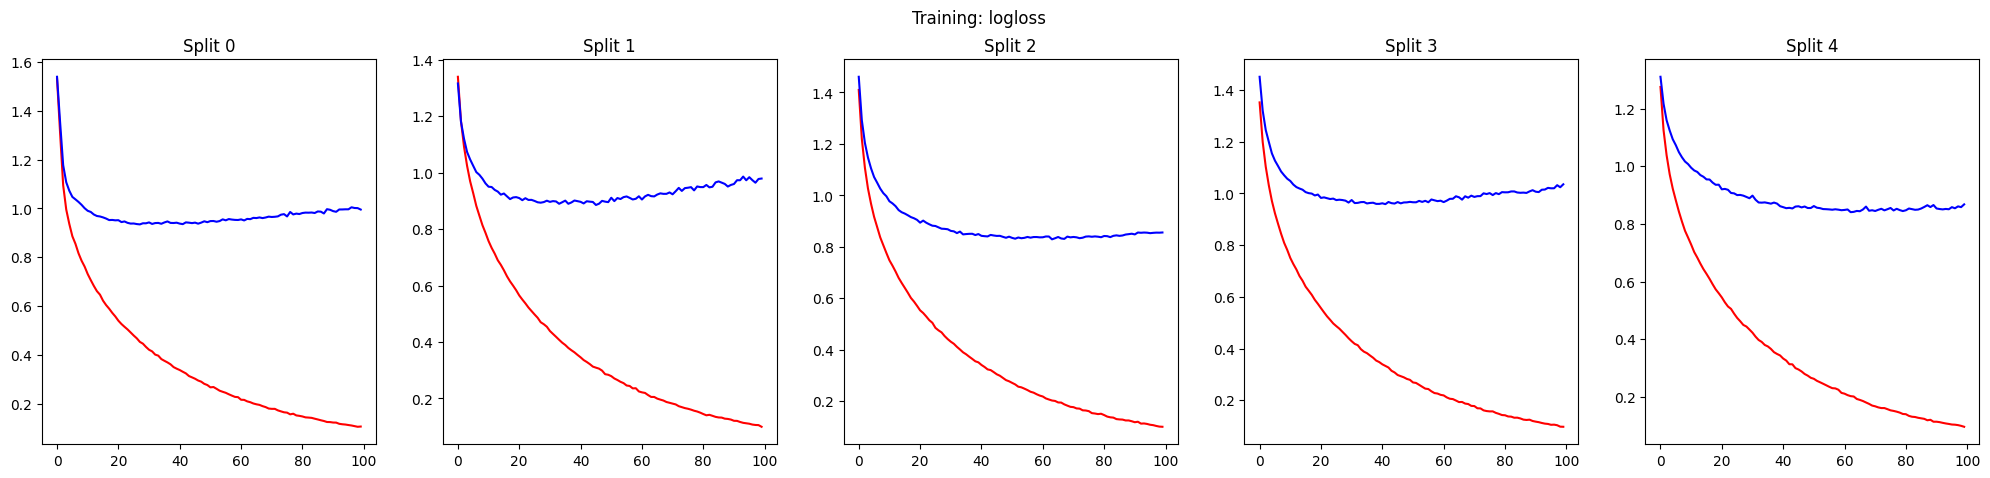

In [32]:
plot_scores(P05_three_layer_output)

In [33]:
sum=0
for i in range(5):
    sum+=P05_three_layer_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6279468215678877, 97)

Eyeballing based on logloss, epoch 40 looks like a reasonable stopping place.

In [34]:
sum.iloc[40]/5

0.5917206440638173

#### Three layer classifier (with L2 regularization)

In [35]:
P05_threelayer_L2=three_layer_classifier(len(P05_t.Label.unique()))

In [49]:
P05_three_layer_L2_output = crossvalid(P05_threelayer_L2, lr=5e-4, wd=.01, n_epochs=300)

0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

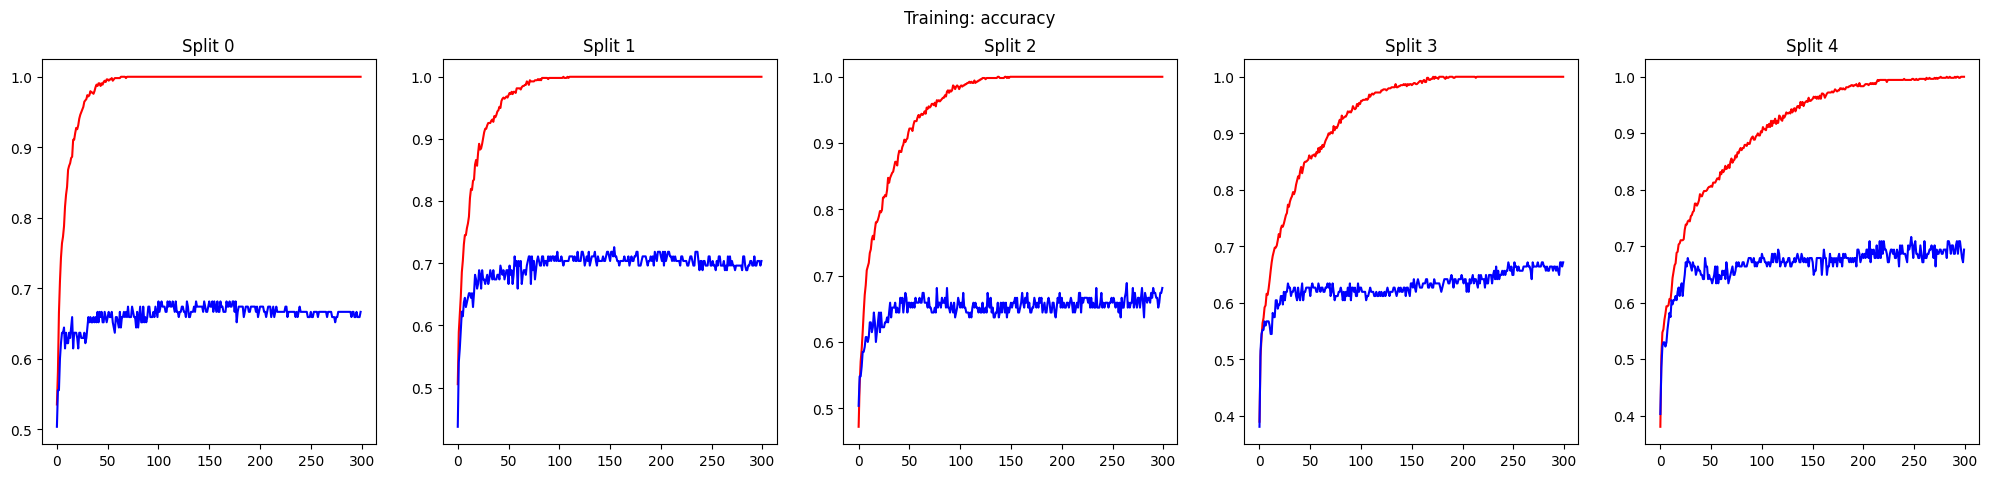

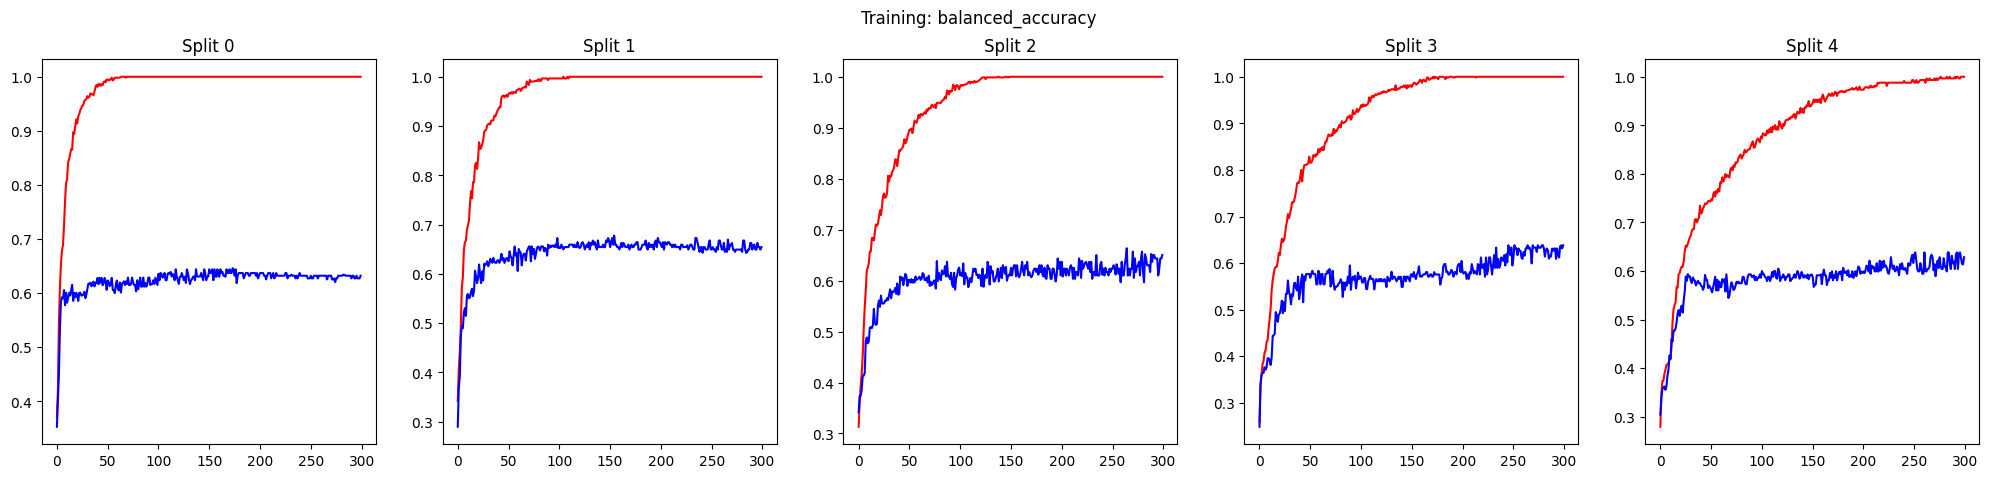

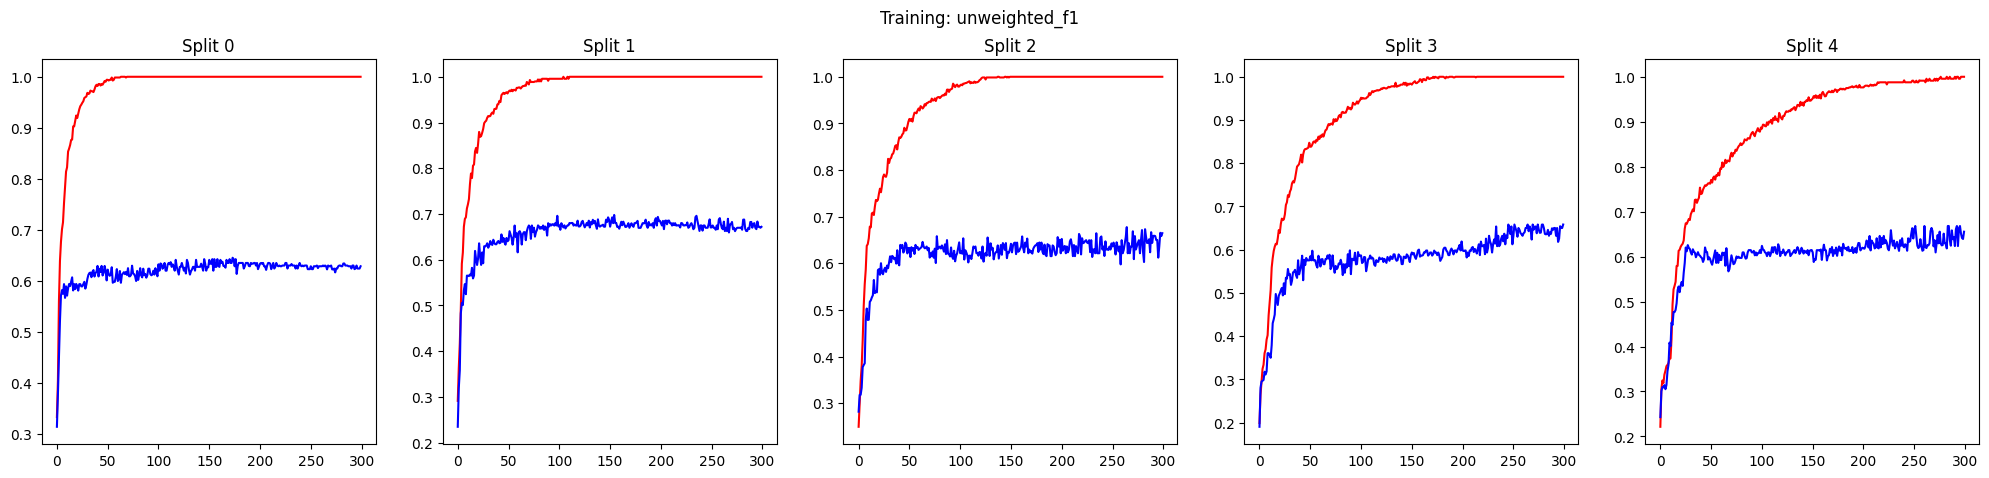

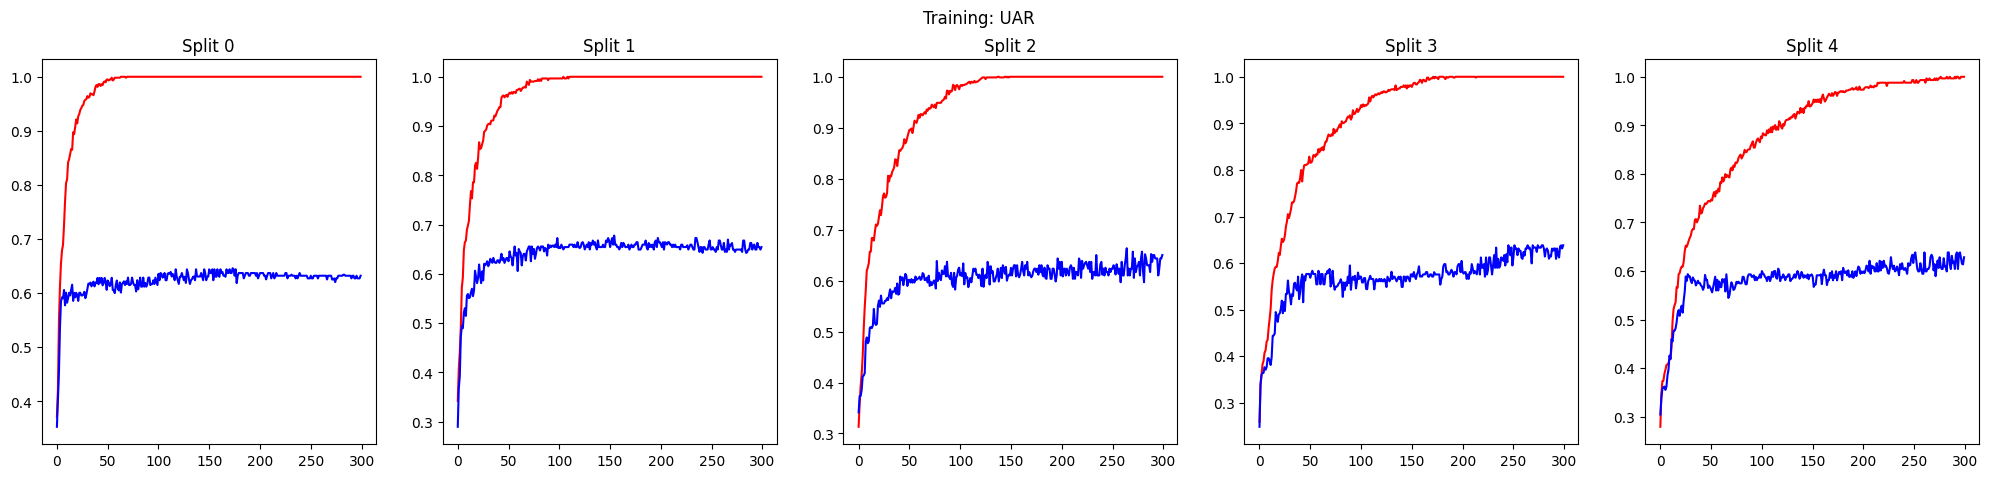

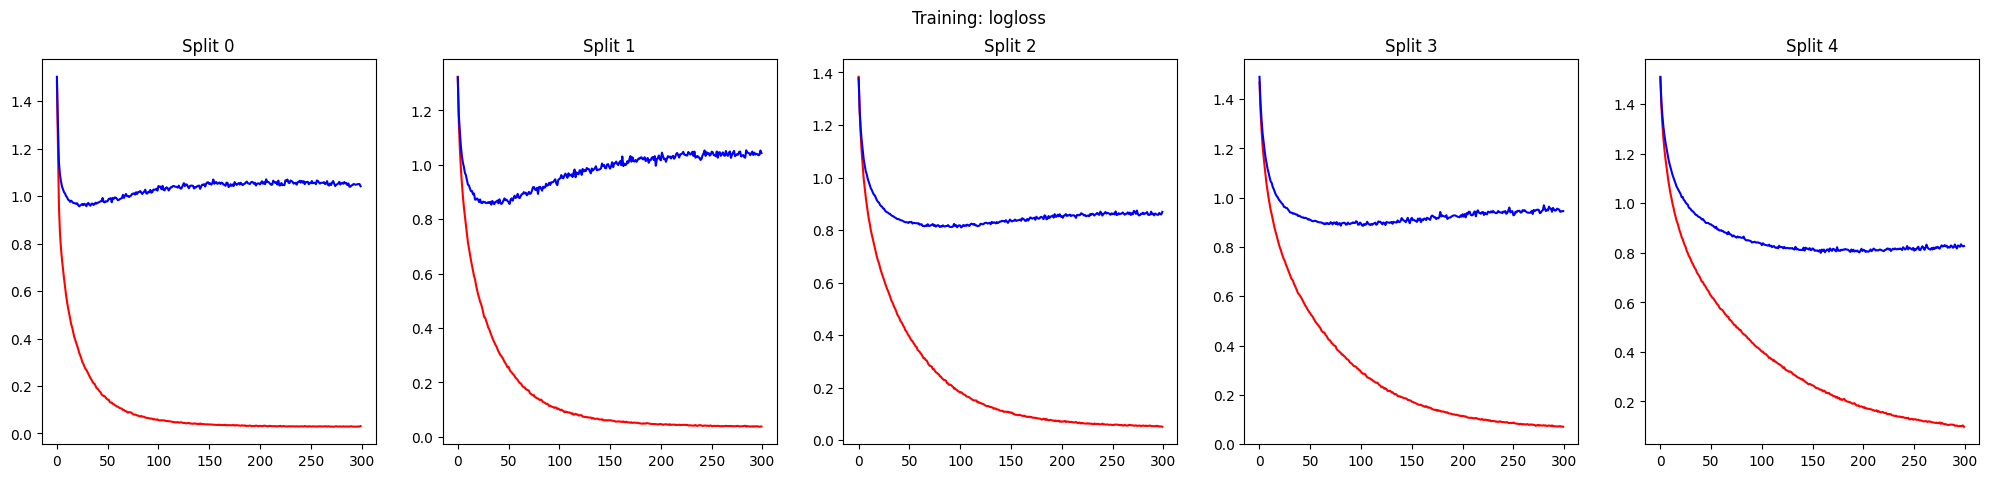

In [37]:
plot_scores(P05_three_layer_L2_output)

In [38]:
sum=0
for i in range(5):
    sum+=P05_three_layer_L2_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6562428357180726, 279)

This one looks wrong to me - stopping training before 50 epochs seems to be much better w.r.t. the logloss training curve.

In [39]:
sum.iloc[50]/5

0.6138916345812786

## MLP Classifiers with dropout

We now try running this process for our two and three layer classifiers, but with dropout implemented. I chose to try dropout at input and in the hidden layers, all with the same dropout rate `dr`.

### Models with dropout

In [40]:
class two_layer_classifier_do(nn.Module):
    def __init__(self, num_labels, dr=.2): #num_labels is the number of labels appearing in the dataframe df we used Features(df), i.e. len(df.Label.unique()), dr=dropout rate
        super().__init__()
        self.dropout0= nn.Dropout(dr)
        self.norm = nn.BatchNorm1d(768) #including a batch normalization layer instead of StandardScaler() (Julian used StandardScaler() when playing with logistic regression) 
        self.layer1 = nn.Linear(768, 768)
        self.act1 = nn.ReLU()
        self.dropout1=nn.Dropout(dr)
        self.output = nn.Linear(768, num_labels)

    def forward(self, x):
        x = self.dropout0(x)
        x = self.norm(x)
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.output(x)
        return x

In [41]:
class three_layer_classifier_do(nn.Module):
    def __init__(self, num_labels, dr=.2): #num_labels is the number of labels appearing in the dataframe df we used Features(df), i.e. len(df.Label.unique()), dr=dropout rate
        super().__init__()
        self.dropout0= nn.Dropout(dr)
        self.norm = nn.BatchNorm1d(768) #including a batch normalization layer instead of StandardScaler() (Julian used StandardScaler() when playing with logistic regression) 
        self.layer1 = nn.Linear(768, 768)
        self.act1 = nn.ReLU()
        self.dropout1=nn.Dropout(dr)
        self.layer2 = nn.Linear(768, 768)
        self.act2 = nn.ReLU()
        self.dropout2=nn.Dropout(dr)
        self.output = nn.Linear(768, num_labels)

    def forward(self, x):
        x = self.dropout0(x)
        x = self.norm(x)
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x

Let's see how these perform.

#### Two layer classifier with dropout

In [42]:
P05_twolayer_do=two_layer_classifier_do(len(P05_t.Label.unique()))

In [43]:
P05_two_layer_do_output = crossvalid(P05_twolayer_do, lr=5e-4, n_epochs=300 )

0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

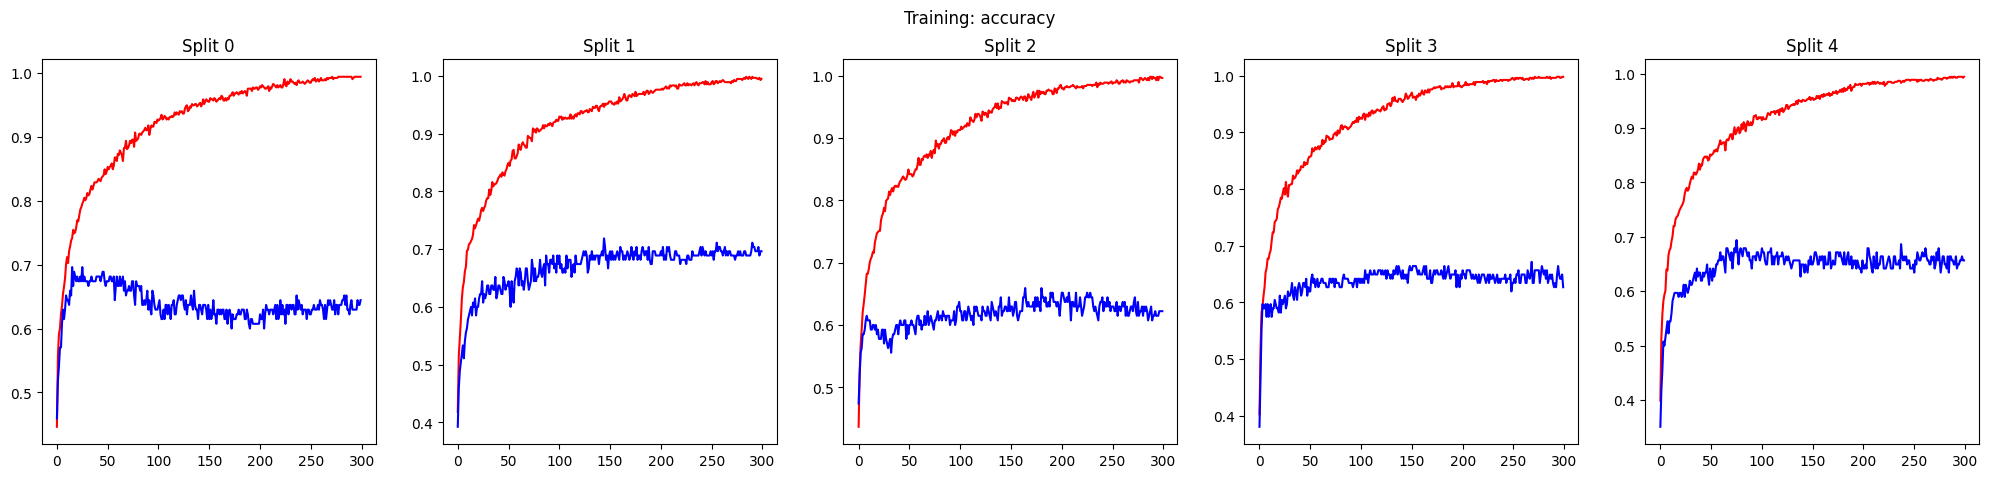

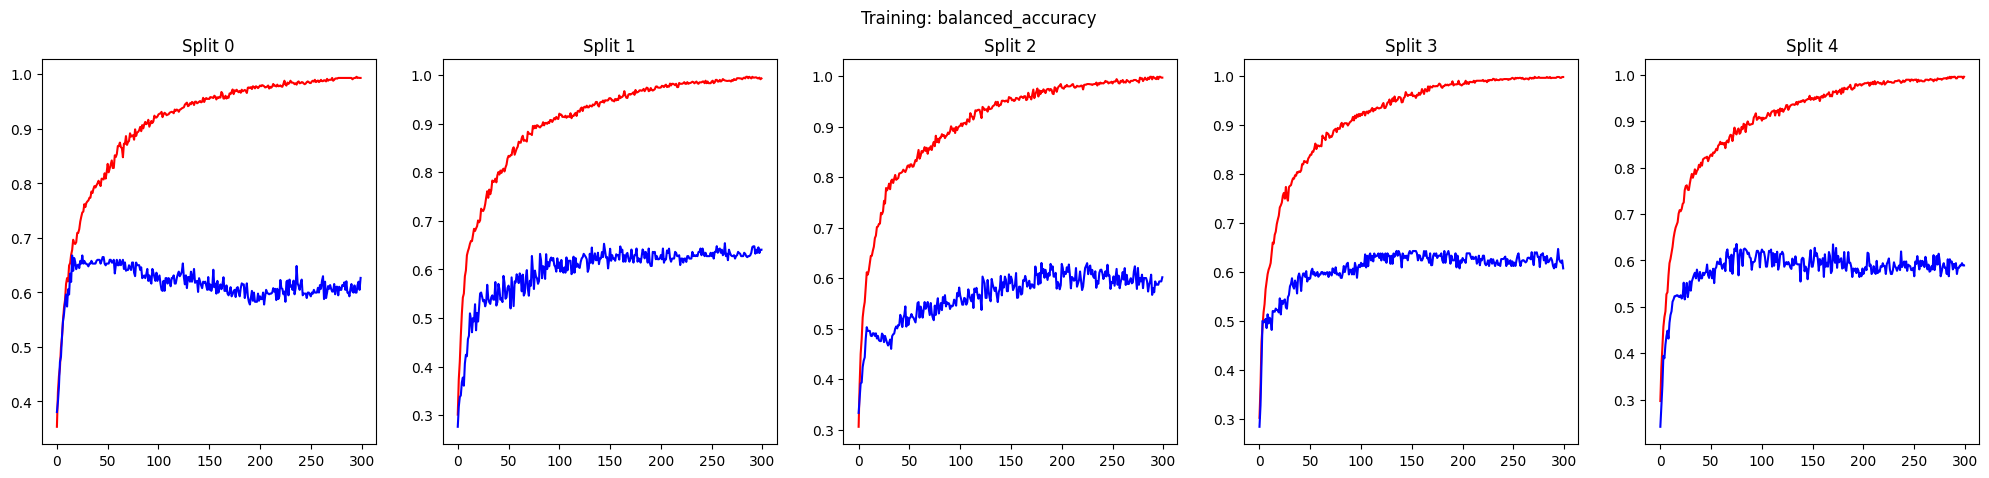

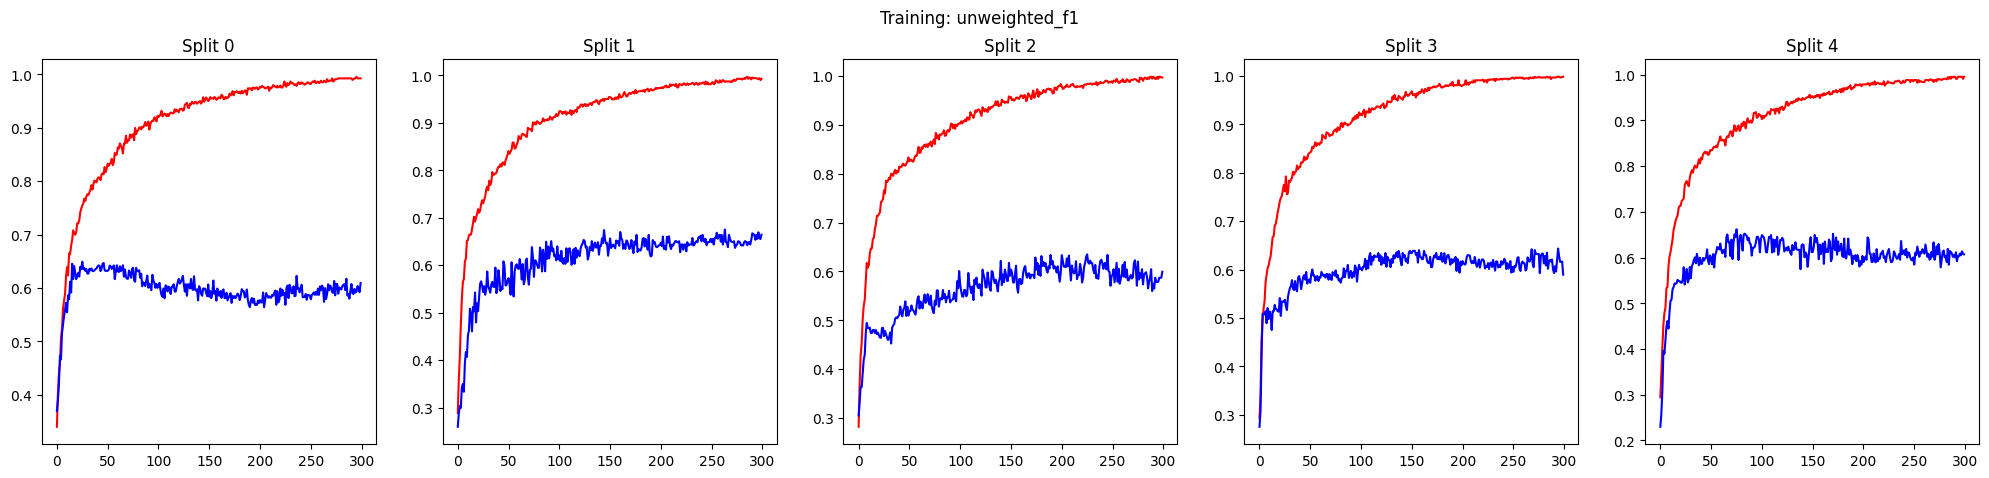

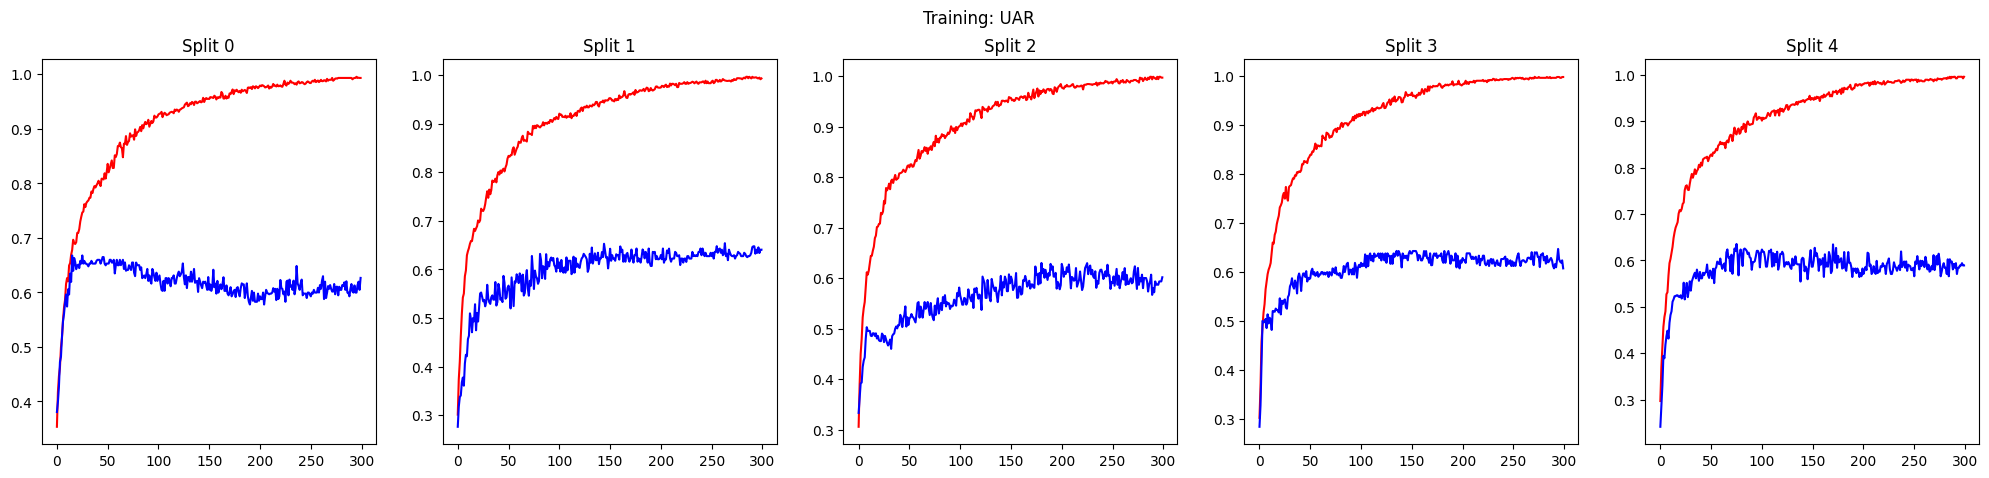

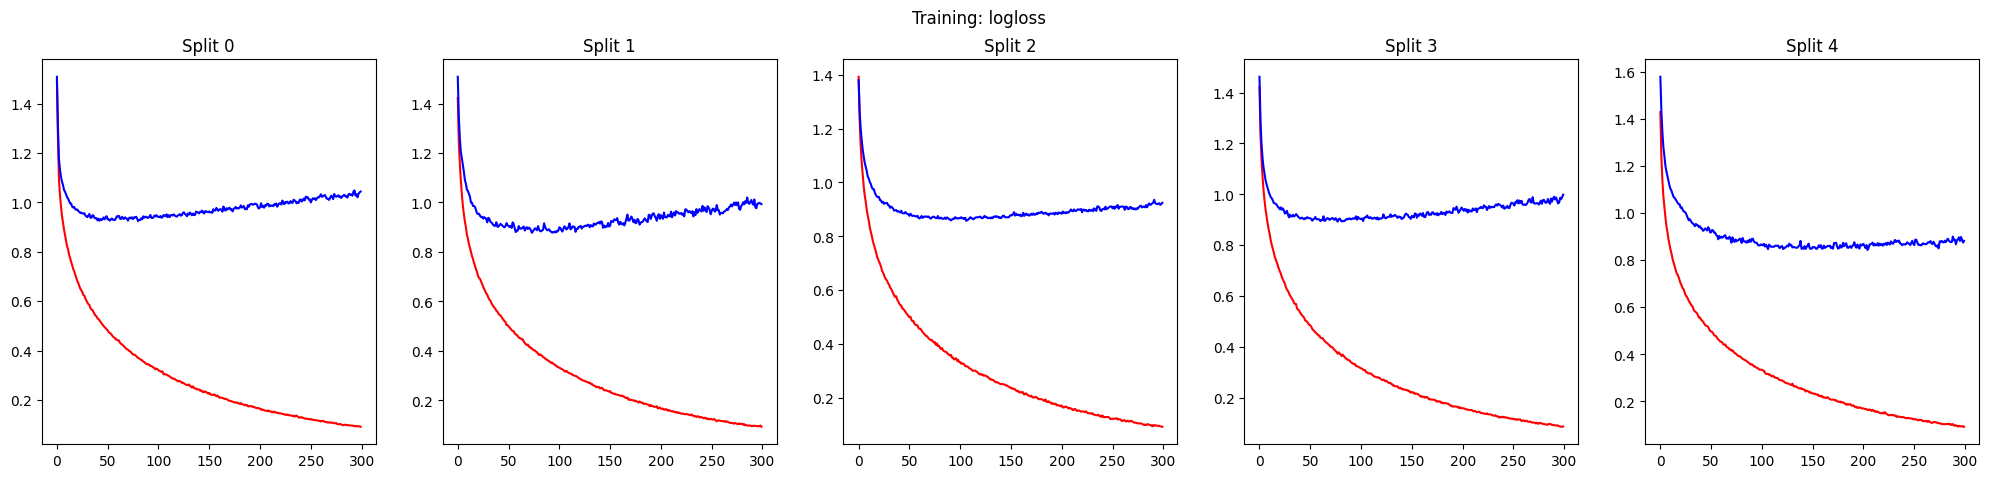

In [44]:
plot_scores(P05_two_layer_do_output)

In [46]:
sum=0
for i in range(5):
    sum+=P05_two_layer_do_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6244115005879539, 272)

#### Two layer classifier with dropout and L2 regularization

In [51]:
P05_twolayer_doL2=two_layer_classifier_do(len(P05_t.Label.unique()))

In [52]:
P05_two_layer_doL2_output = crossvalid(P05_twolayer_doL2, lr=5e-4, wd=.01, n_epochs=300 )


0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

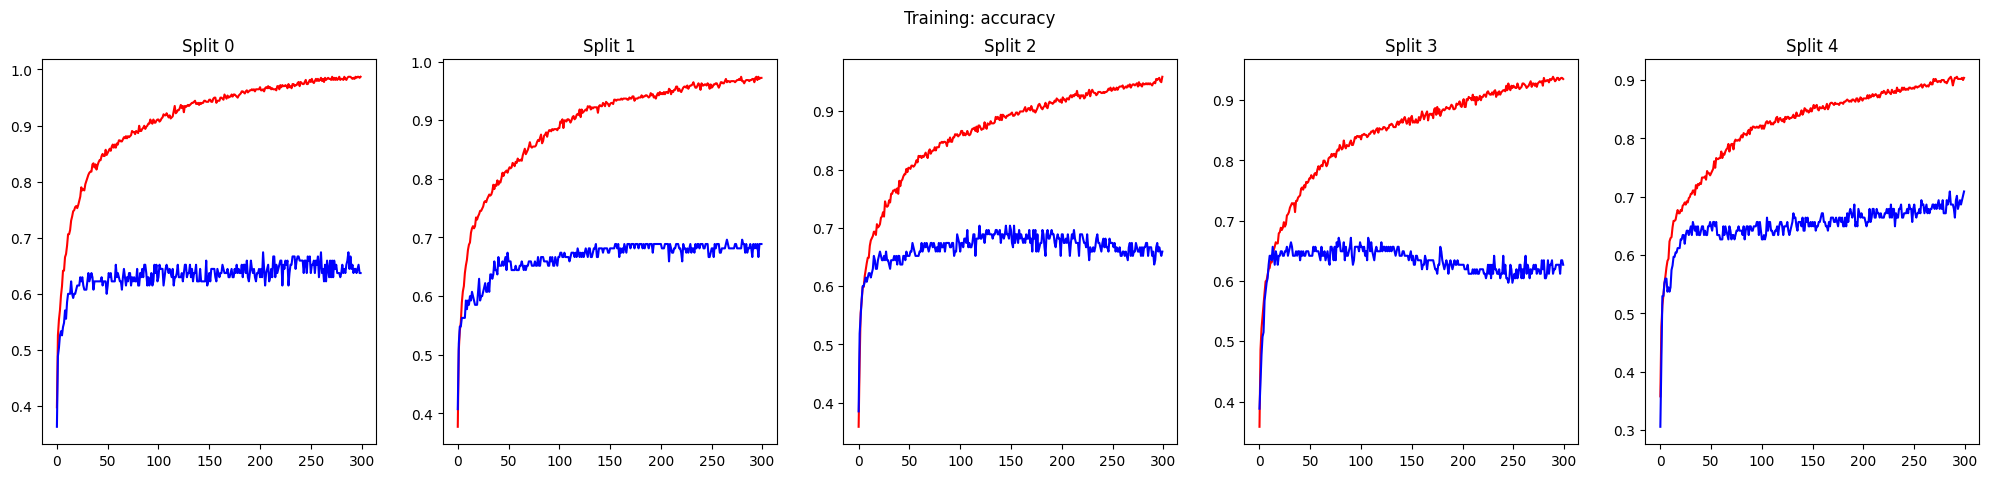

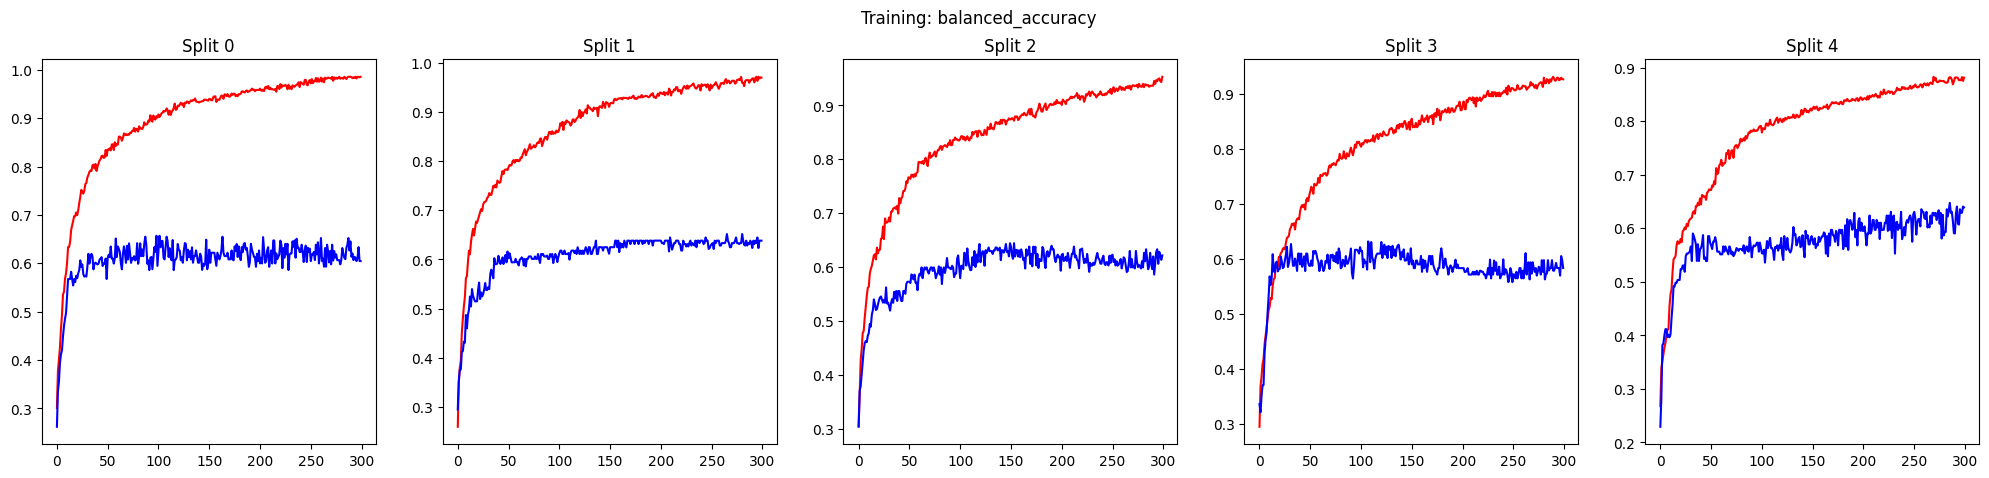

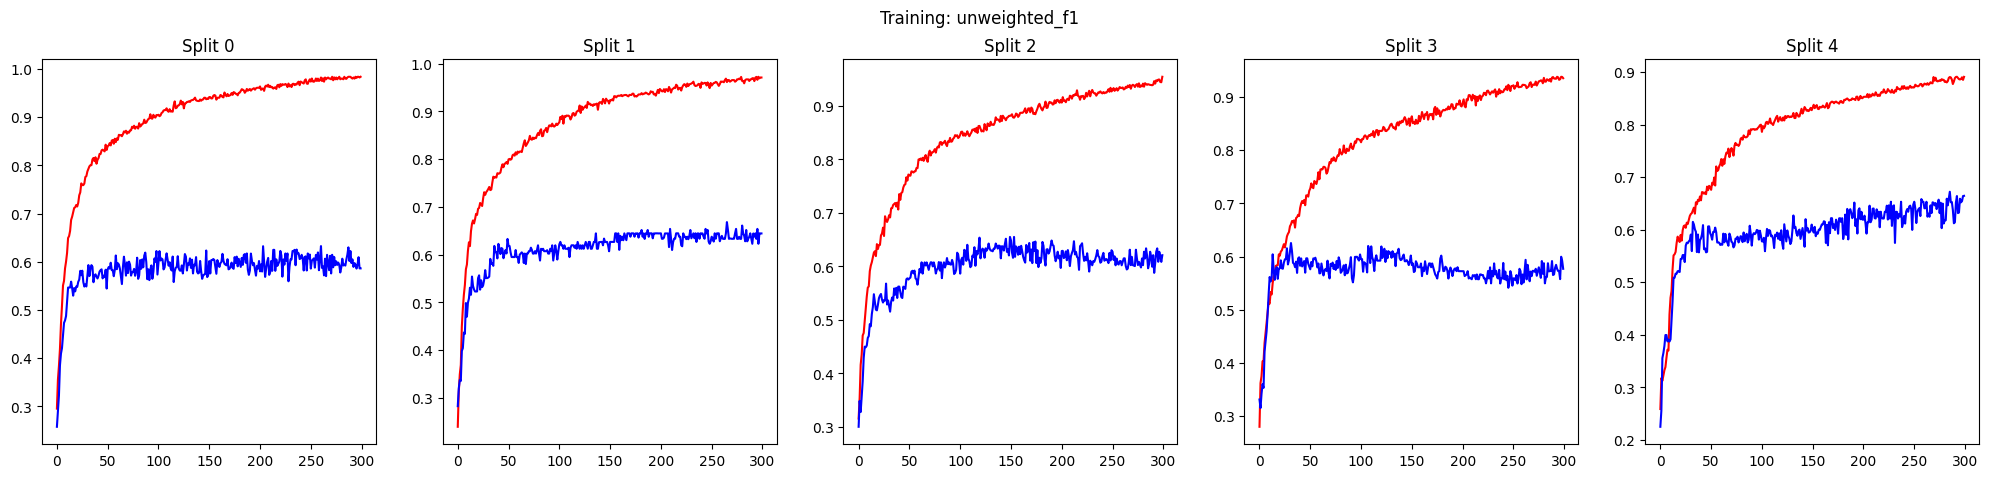

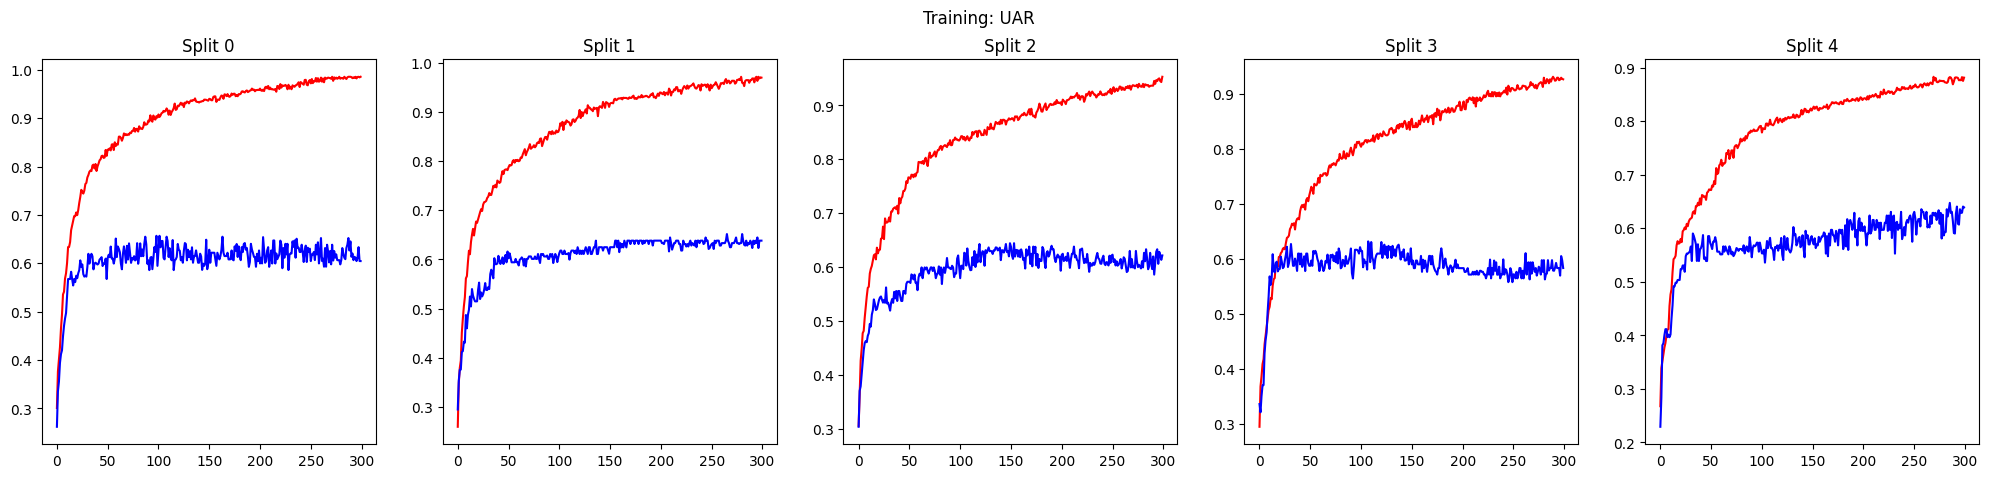

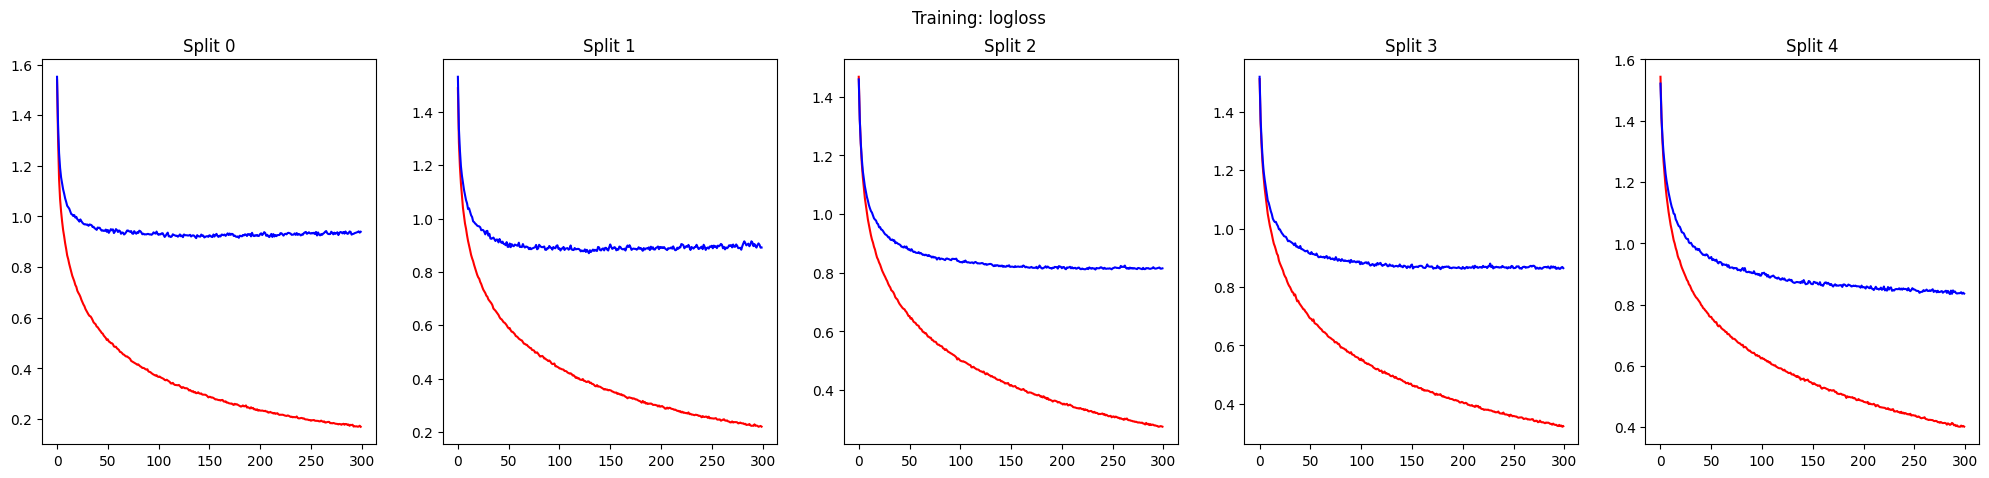

In [53]:
plot_scores(P05_two_layer_doL2_output)

In [54]:
sum=0
for i in range(5):
    sum+=P05_two_layer_doL2_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6254613763342122, 297)

Looks very comparable to the model with dropout, but without regularization.

#### Three layer classifier with dropout

In [55]:
P05_threelayer_do=three_layer_classifier_do(len(P05_t.Label.unique()))

In [56]:
P05_three_layer_do_output = crossvalid(P05_threelayer_do, lr=5e-4, wd=.01, n_epochs=300)

0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

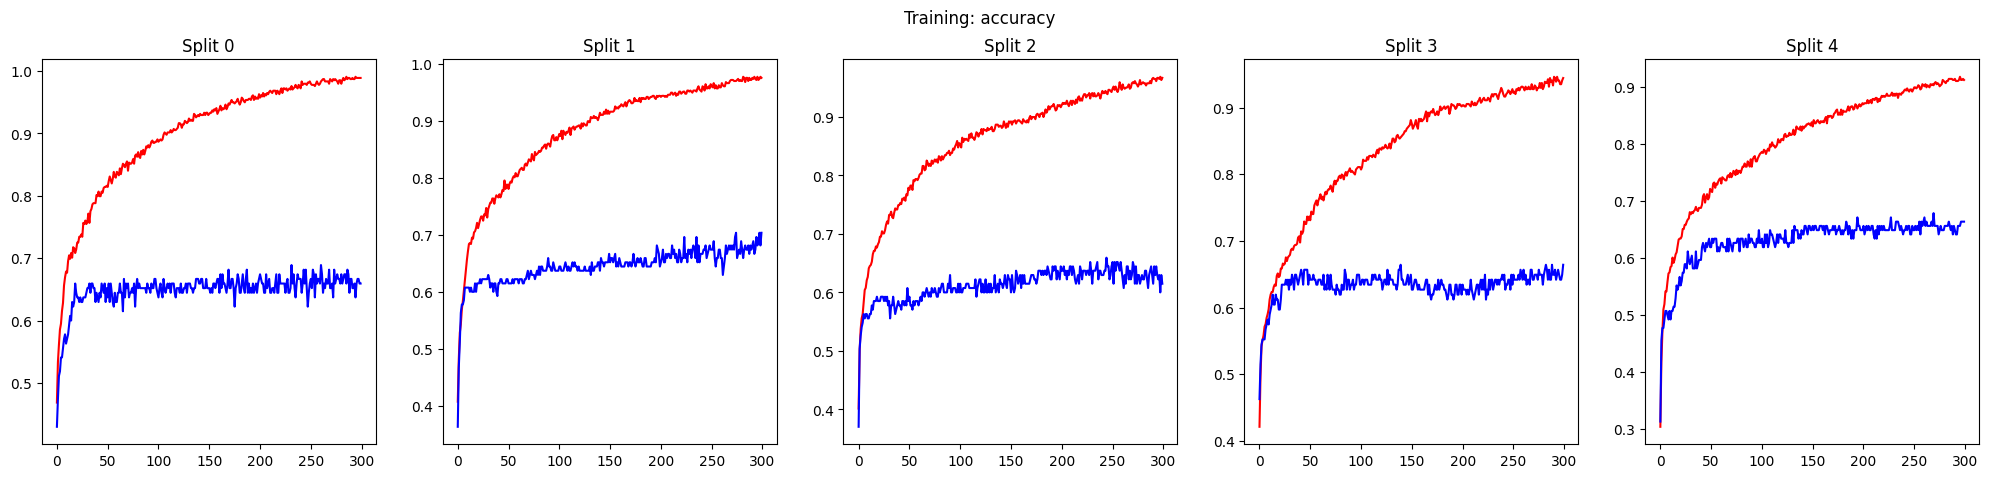

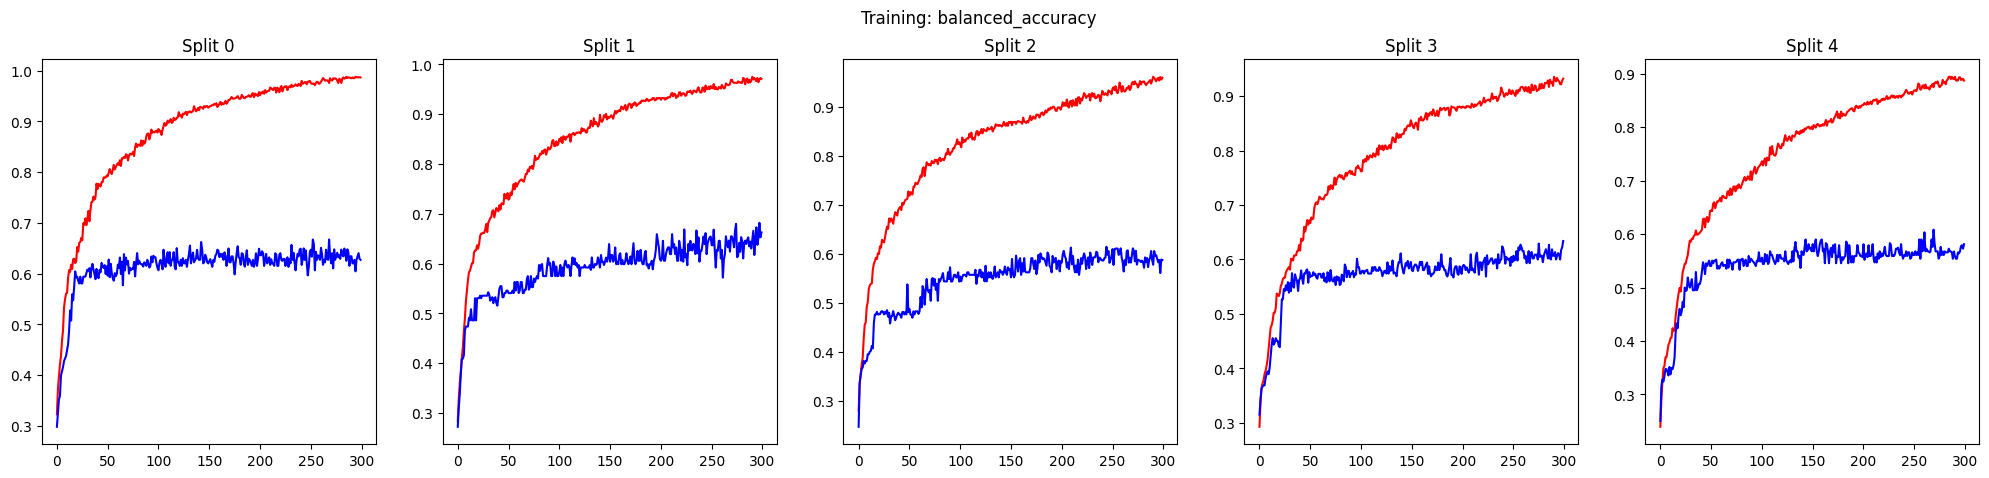

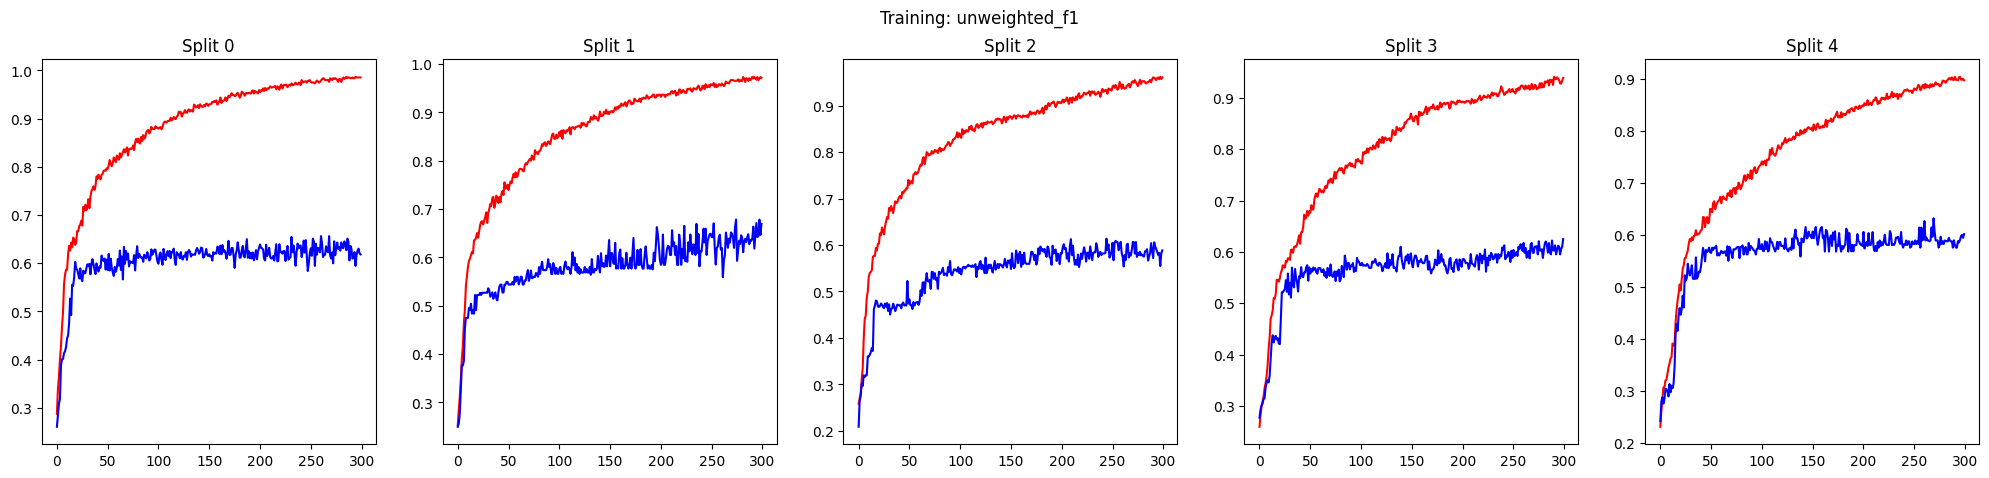

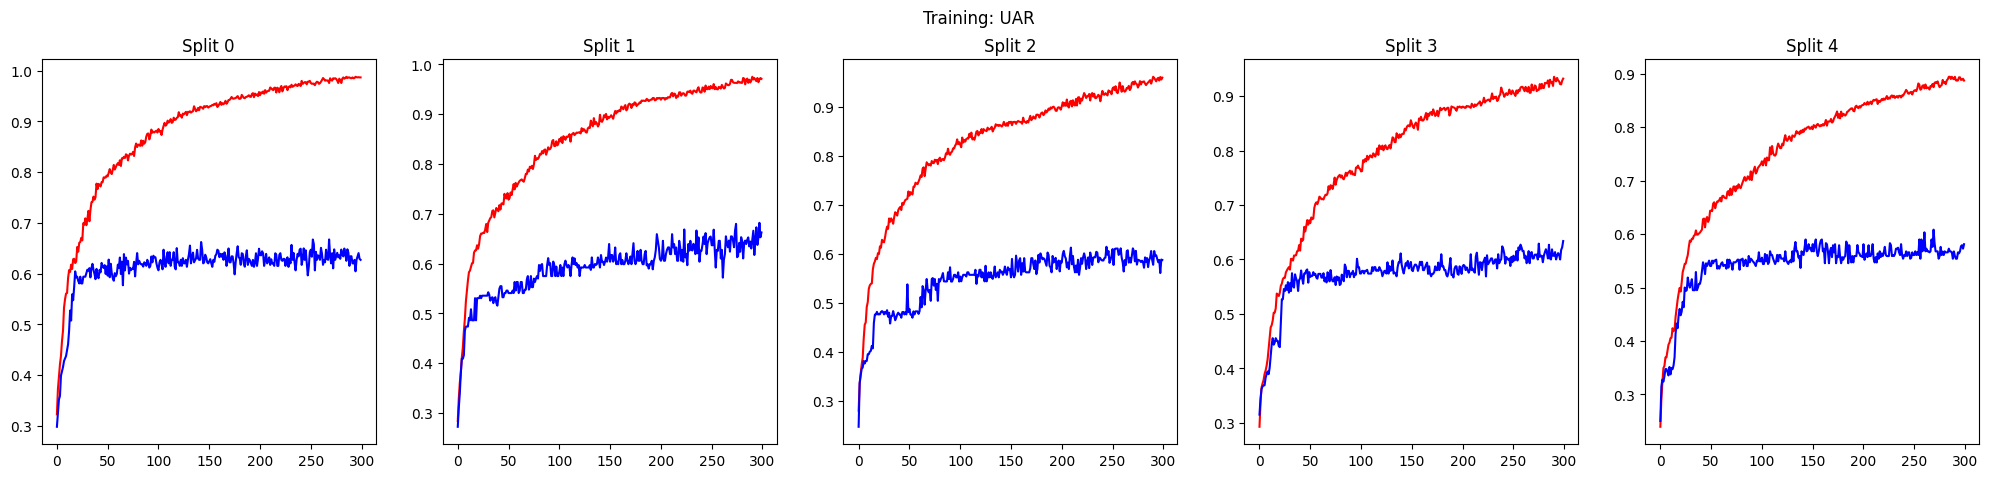

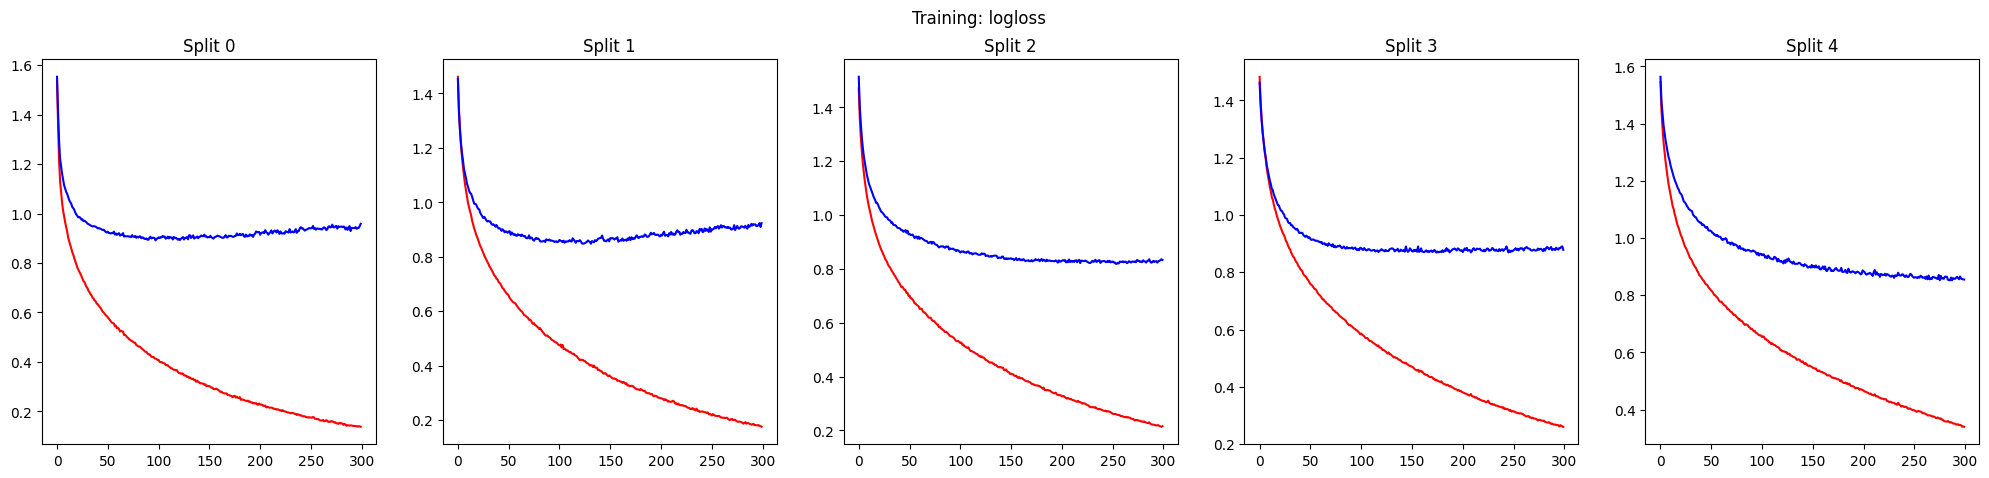

In [57]:
plot_scores(P05_three_layer_do_output)

In [58]:
sum=0
for i in range(5):
    sum+=P05_three_layer_do_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6229311181670821, 273)

#### Three layer classifier with dropout and L2 regularization

In [59]:
P05_threelayer_doL2=three_layer_classifier_do(len(P05_t.Label.unique()))

In [60]:
P05_three_layer_doL2_output = crossvalid(P05_threelayer_doL2, lr=5e-4, wd=.01, n_epochs=300 )

0-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

1-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

2-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

3-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

4-th Fold:


  0%|          | 0/300 [00:00<?, ?it/s]

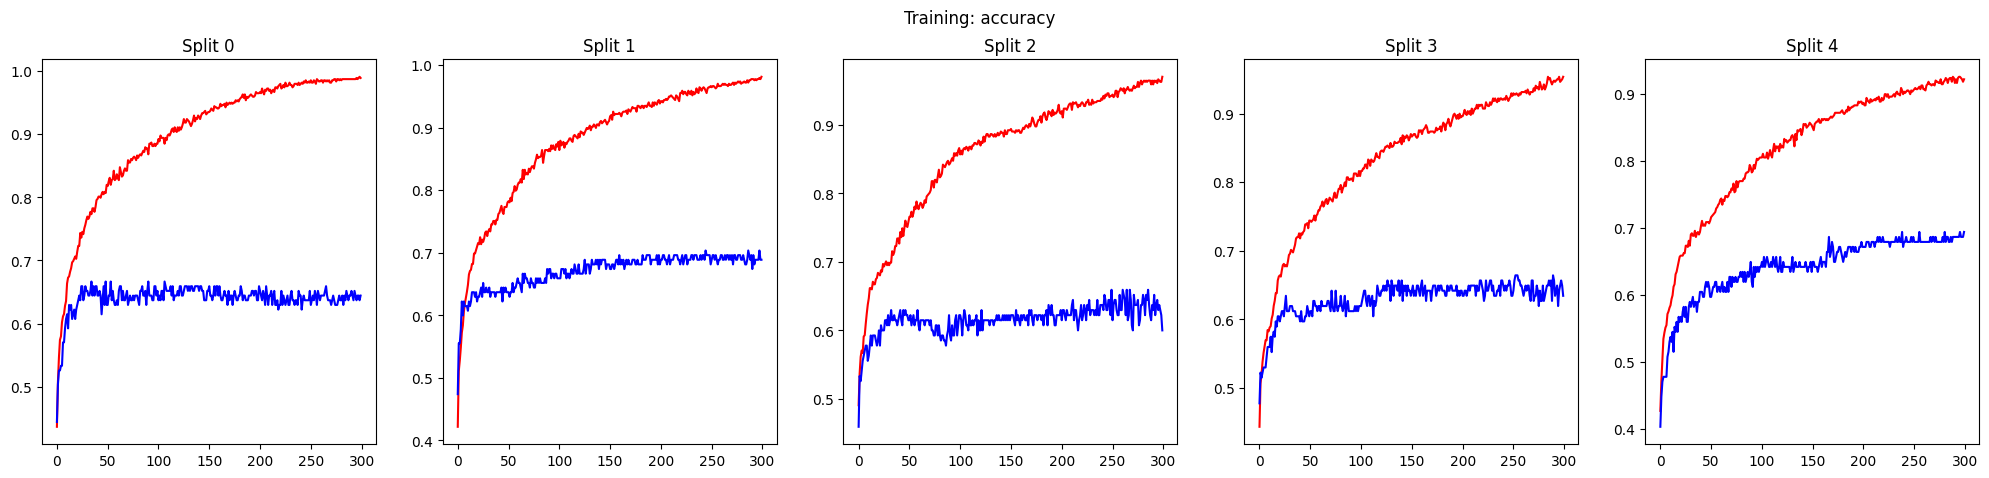

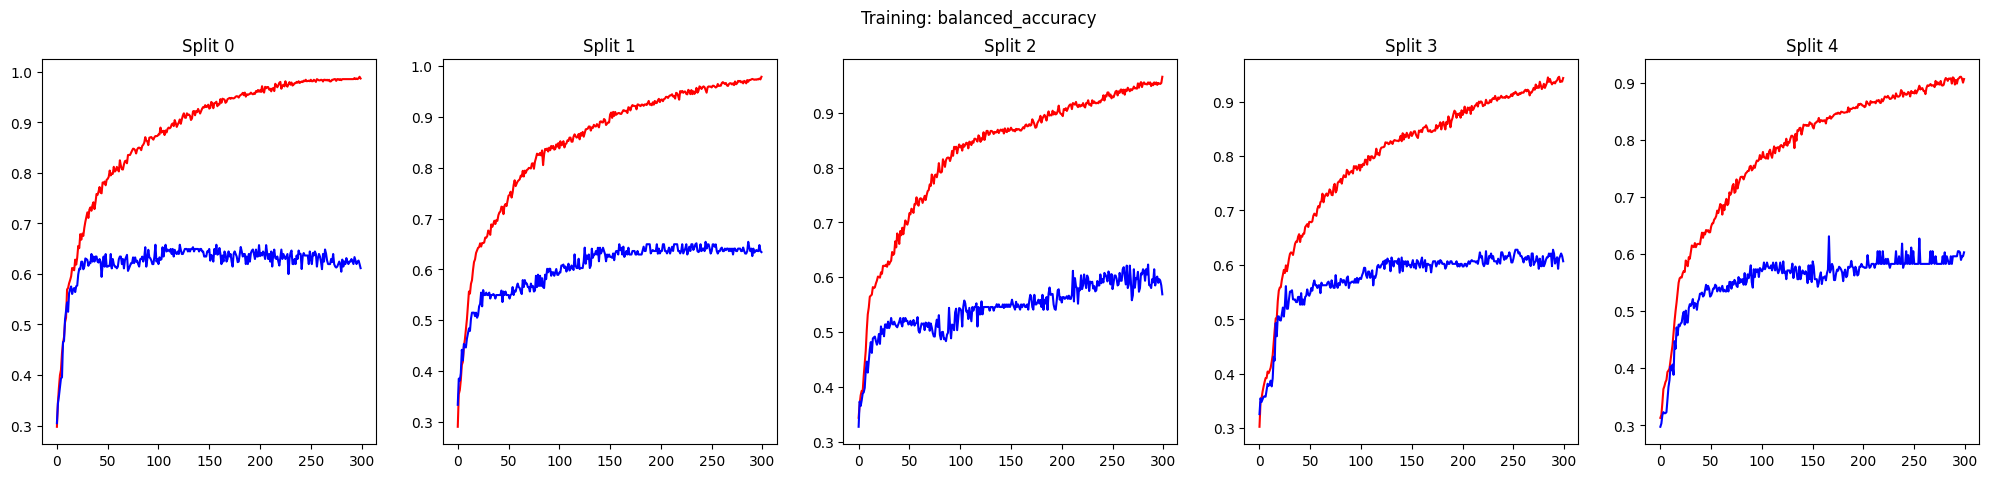

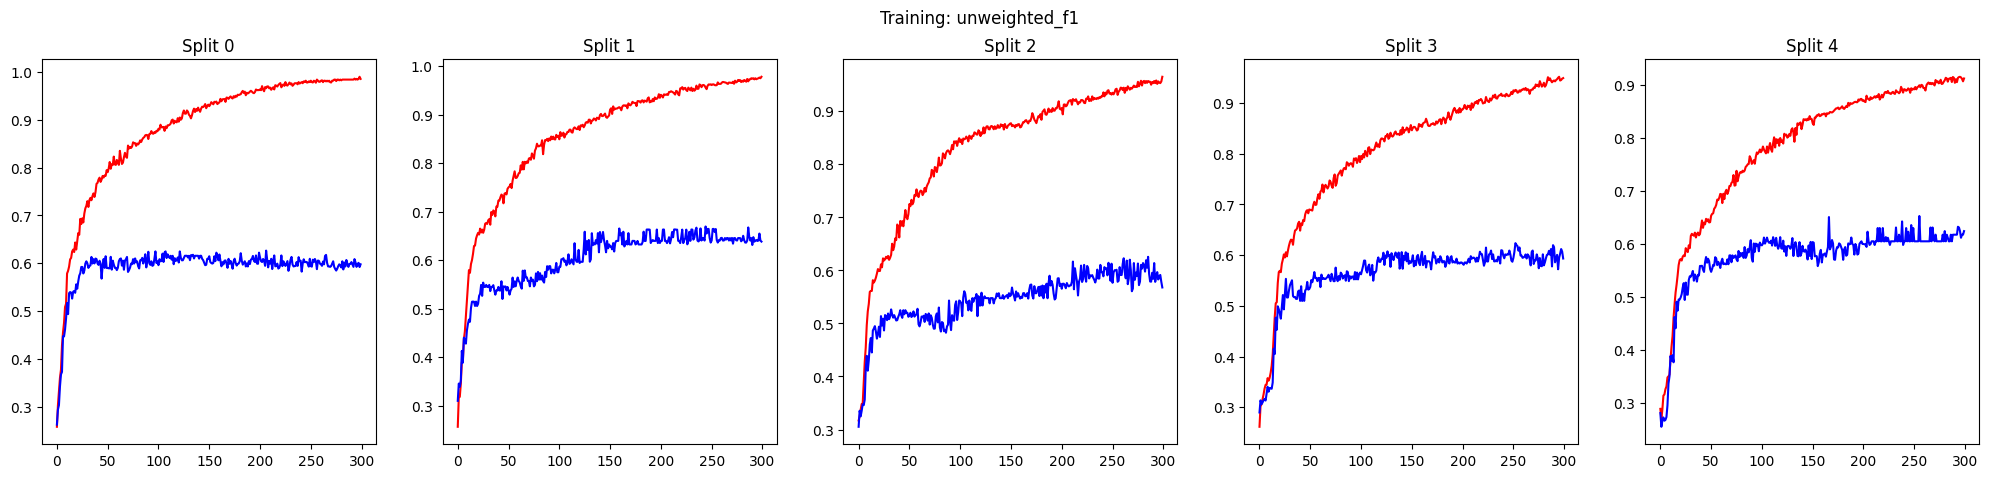

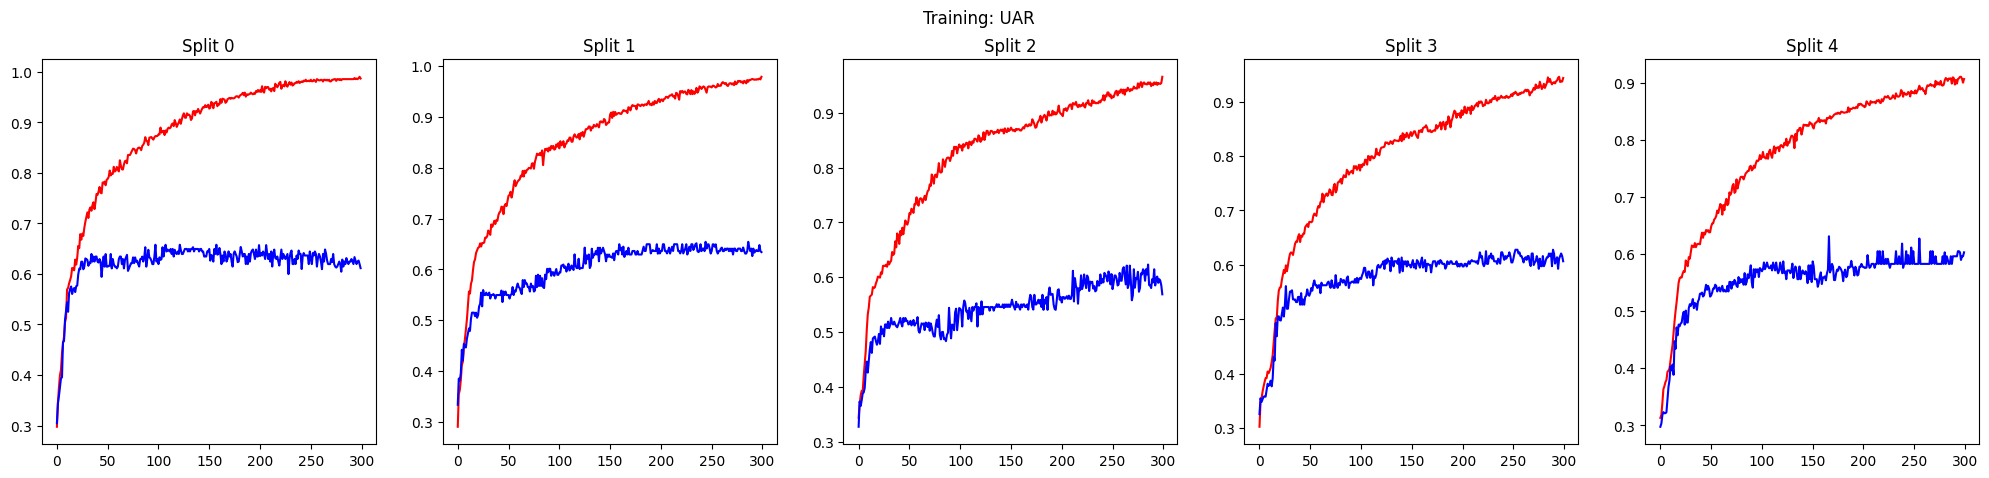

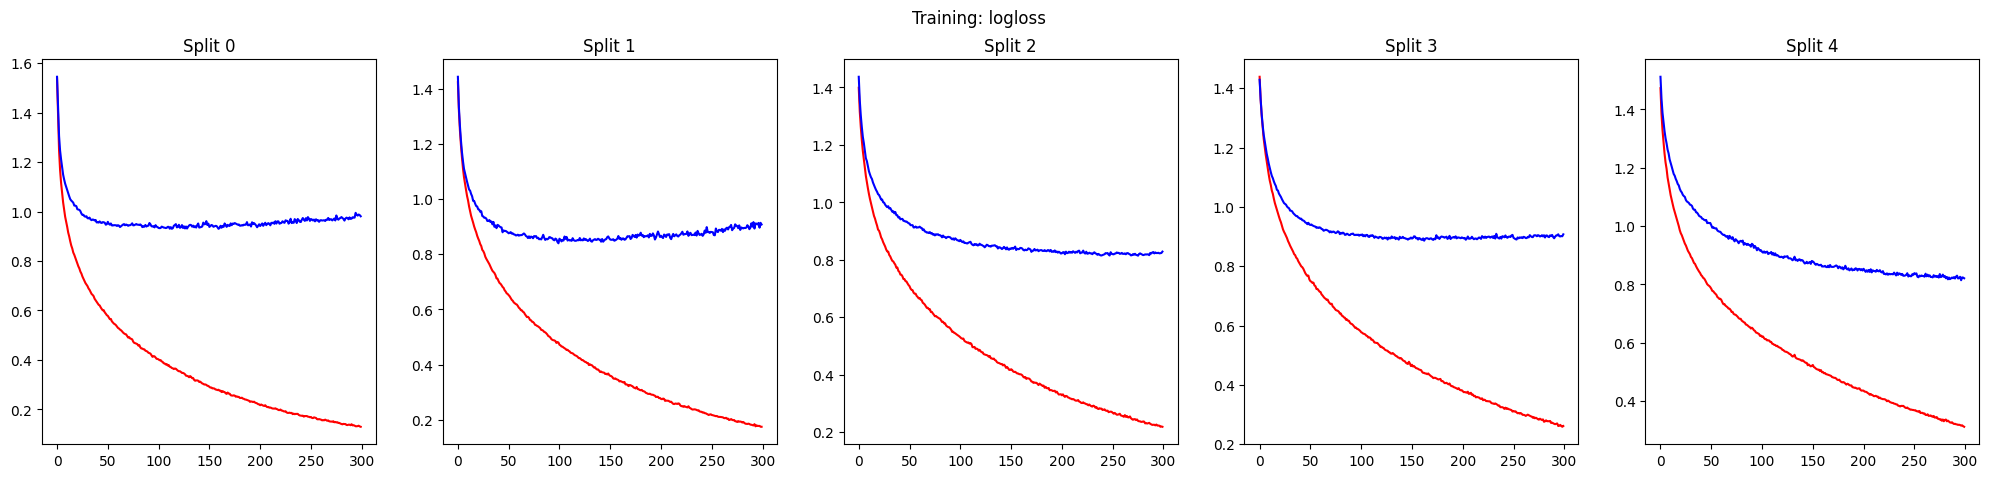

In [61]:
plot_scores(P05_three_layer_doL2_output)

In [62]:
sum=0
for i in range(5):
    sum+=P05_three_layer_do_output["unweighted_f1"][f'split_{i}_val']
avg_f1_val=sum.max()/5
stop=sum.argmax()
avg_f1_val, stop

(0.6229311181670821, 273)